# California Price Prediction

In this notebook we will use the [California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices) dataset to apply some EDA techniques and implement diverse regression models to accurately predict the price of the houses based on different variables.

## Importing libraries

In [111]:
#EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

#clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

#regression section
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the dataset

In [3]:
working_dir = "/content/drive/MyDrive/Proyectos/California_Regression/"

In [4]:
df_california = pd.read_csv(working_dir+"Data/housing.csv")

In [5]:
df_california.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

## Exploratory Analysis

 ### Initial EDA

Let's get familiar with the data that we have and see if we need to correct some of them or we are able to get some useful insight before the prediciton section.

In [6]:
df_california.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


With the exception of `ocean_proximity`, every other variable has numeric values, something that we could expected.

The `total_bedrooms` ones has some missing values. As they are not a lot, we can simply drop them.

In [7]:
df_california_2 = df_california.dropna()

In [8]:
df_california_2["ocean_proximity"].value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

All these values look like valid ones. We can start to see that the distribution of their counts, and probably prices, won´t be uniform since it looks like most of the houses are very proximate to the ocean.

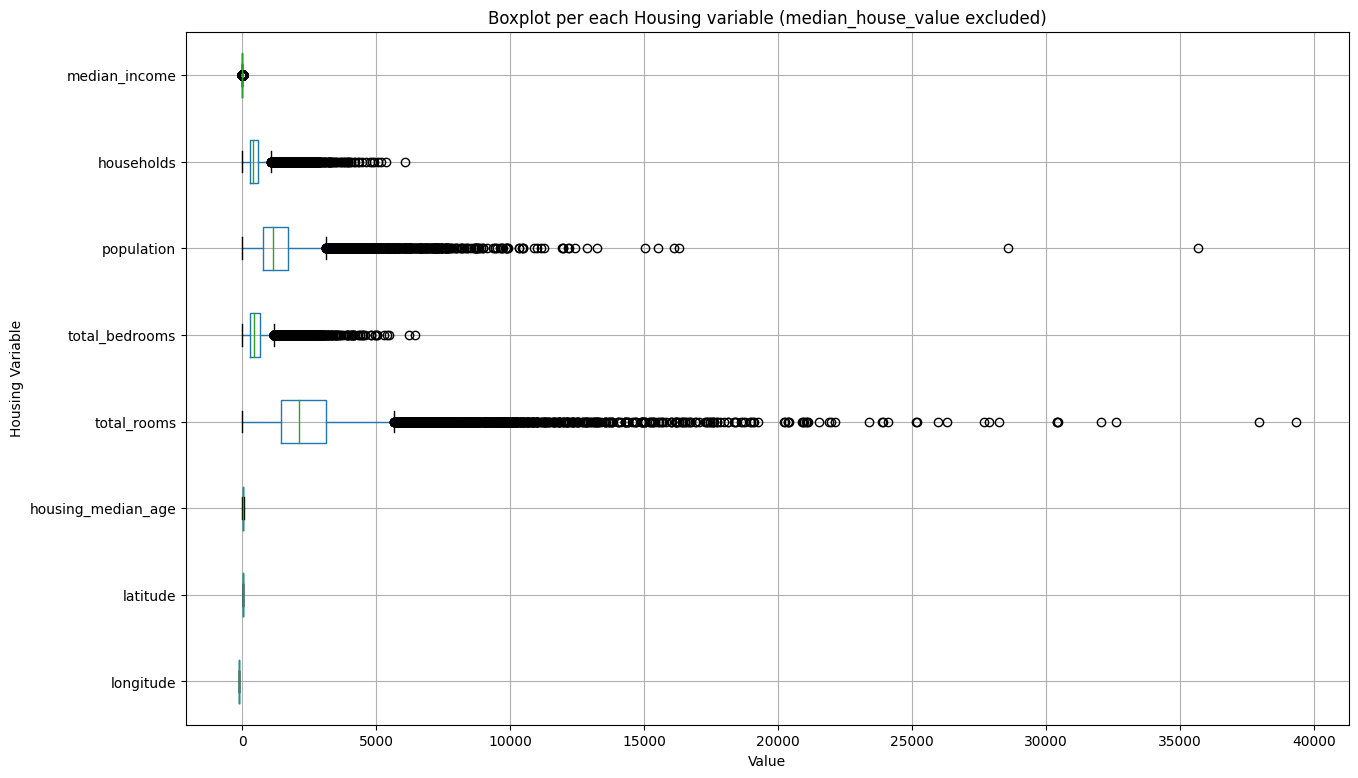

In [9]:
plt.figure(figsize=(15, 9))
df_california_2.drop(columns=["median_house_value"]).boxplot(vert=False)
plt.ylabel("Housing Variable")
plt.xlabel("Value")
plt.title("Boxplot per each Housing variable (median_house_value excluded)")
plt.show()

This doesn´t look good, since they use different scales, it will be better to do a boxplot per each of the variables that we have.

In [10]:
numerical_data = df_california_2.drop(columns=["ocean_proximity"])

In [11]:
cols = numerical_data.columns
len(cols)

9

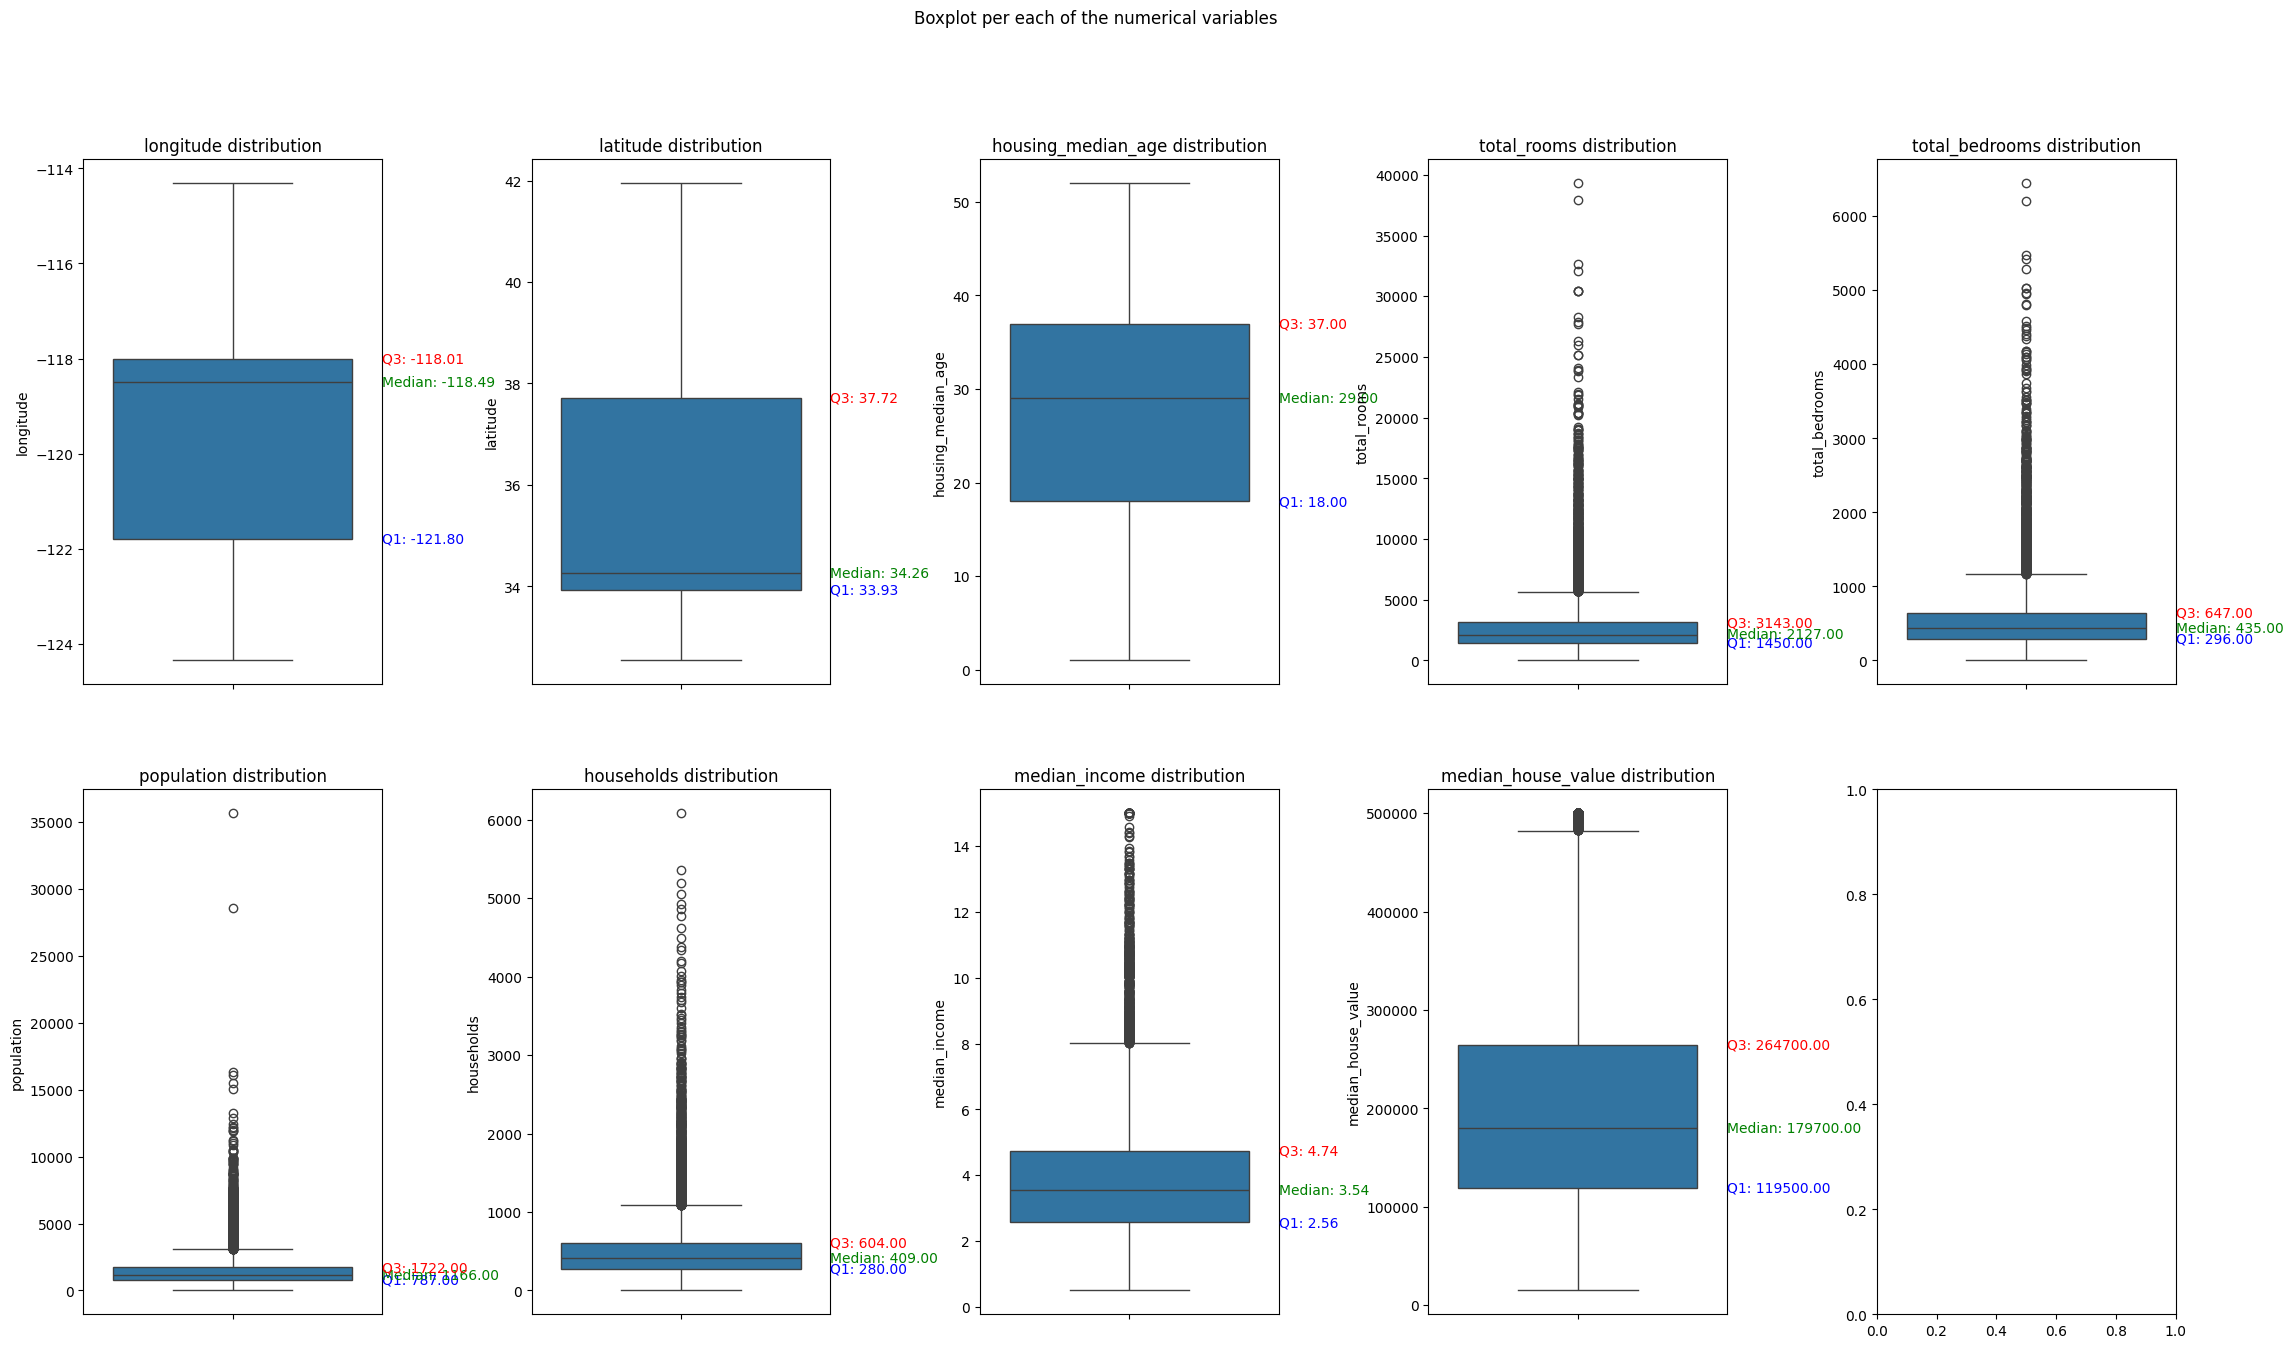

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(27, 15))
ax = ax.flatten()
fig.subplots_adjust(wspace=0.5)

for i in range(0, len(cols)):

    variable = cols[i]
    variable_data = numerical_data[variable]

    quantile_25 = variable_data.quantile(0.25)
    median = variable_data.quantile(0.50)
    quantile_75 = variable_data.quantile(0.75)

    sns.boxplot(y = variable_data, ax=ax[i])

    ax[i].text(0.50, quantile_25, f'Q1: {quantile_25:.2f}', verticalalignment='center', color='blue', fontsize=10)
    ax[i].text(0.50, median, f'Median: {median:.2f}', verticalalignment='center', color='green', fontsize=10)
    ax[i].text(0.50, quantile_75, f'Q3: {quantile_75:.2f}', verticalalignment='center', color='red', fontsize=10)

    ax[i].set_title(f"{variable} distribution")



plt.suptitle("Boxplot per each of the numerical variables")
plt.show()

While the `Longitude` and `Latitude` looks like have a bias to higher and lower values respectively (we will see that is makes sense if we consider California's geographic shape), the `housing_median_age` is pretty simetric. Similar look `median_house_value`, but with an slighlty more centered to lower values boxplot body.

For all the other boxplots, we can see a really big amount of outliers, at least based on the boxplot 1.5 IQR criteria.

Because of their quantity, they don´t really seem like so.

But as we have a categorical variable in our dataset, `ocean_proximity`, we can see if this trend persists we we discriminate the data based on this.

In [13]:
ocean_proximity = df_california_2["ocean_proximity"]

<ipython-input-14-0635c551080c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(ax[i].get_yticklabels())
<ipython-input-14-0635c551080c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(ax[i].get_yticklabels())
<ipython-input-14-0635c551080c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(ax[i].get_yticklabels())
<ipython-input-14-0635c551080c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(ax[i].get_yticklabels())
<ipython-input-14-0635c551080c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(ax[i].get_yticklabels())
<ipython-input-14-0635c551080c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(ax[i].get_yticklabels())
<ipython-input-14-0635c551080c>:22: User

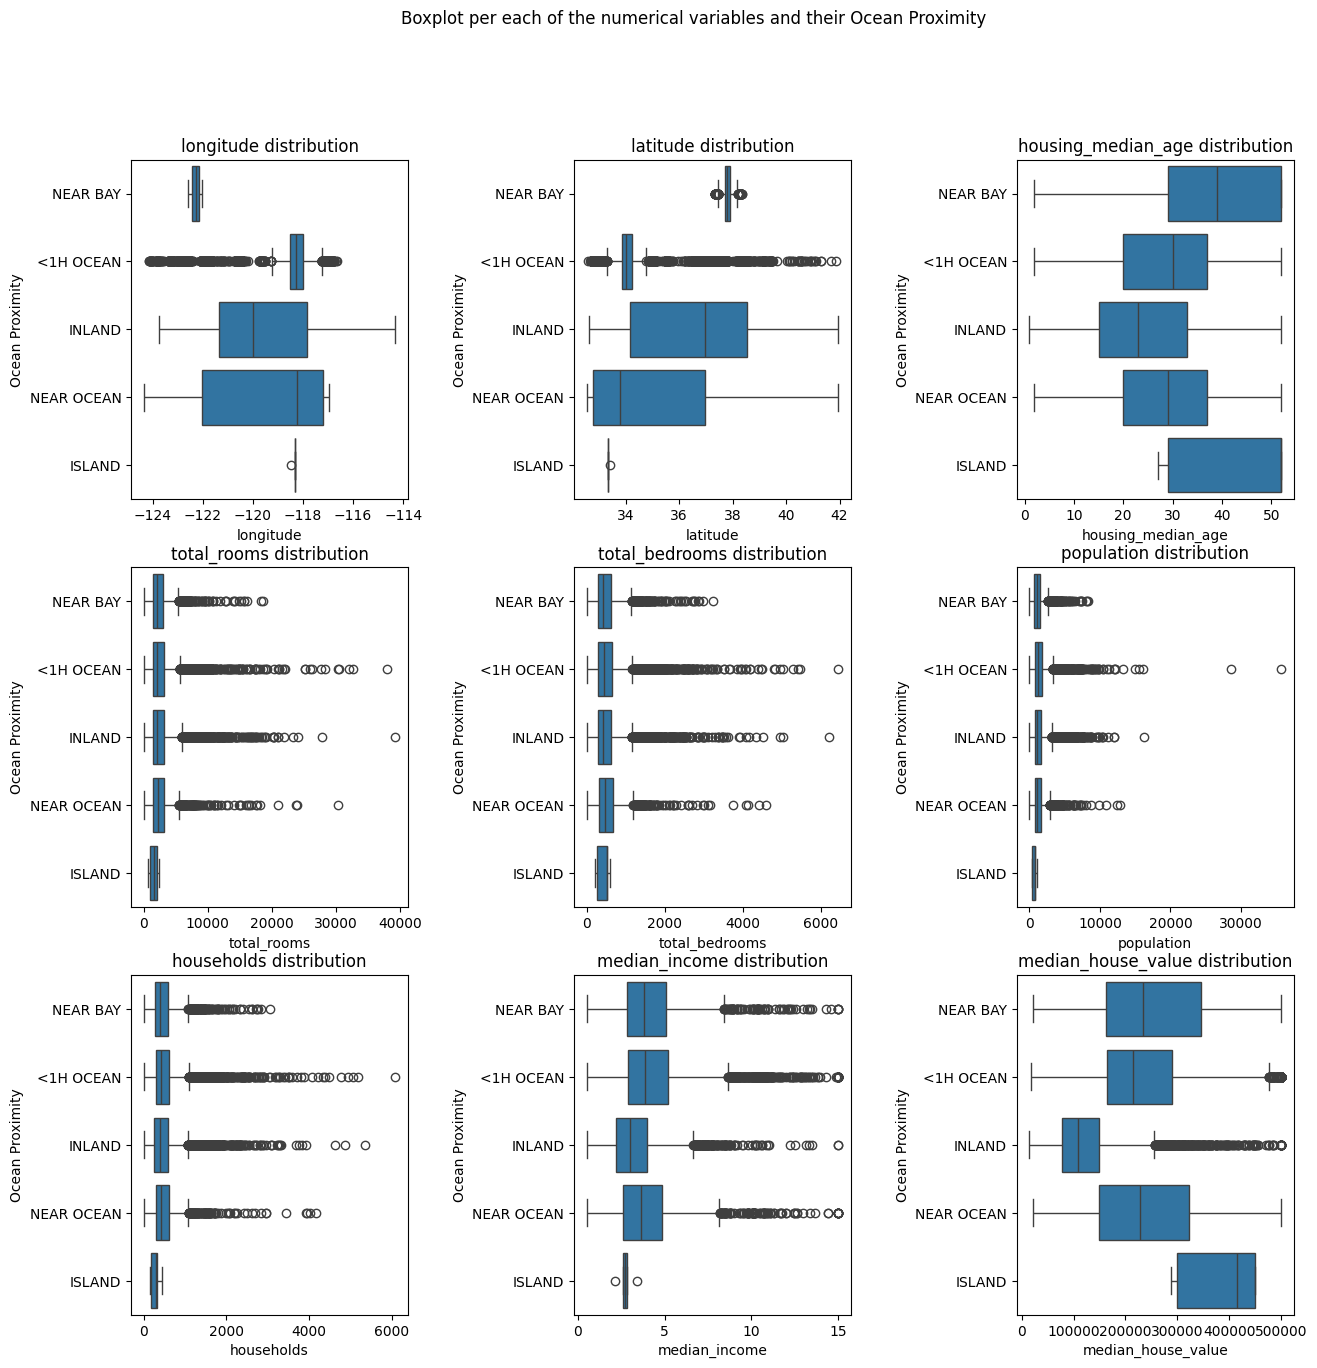

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
ax = ax.flatten()
fig.subplots_adjust(wspace=0.6, hspace=0.2)

for i in range(0, len(cols)):

    variable = cols[i]
    variable_data = numerical_data[variable]

    quantile_25 = variable_data.quantile(0.25)
    median = variable_data.quantile(0.50)
    quantile_75 = variable_data.quantile(0.75)

    sns.boxplot(x = variable_data, ax=ax[i], y=ocean_proximity)

    #ax[i].text(0.50, quantile_25, f'Q1: {quantile_25:.2f}', verticalalignment='center', color='blue', fontsize=10)
    #ax[i].text(0.50, median, f'Median: {median:.2f}', verticalalignment='center', color='green', fontsize=10)
    #ax[i].text(0.50, quantile_75, f'Q3: {quantile_75:.2f}', verticalalignment='center', color='red', fontsize=10)

    ax[i].set_title(f"{variable} distribution")
    ax[i].set_ylabel("Ocean Proximity")
    ax[i].set_yticklabels(ax[i].get_yticklabels())



plt.suptitle("Boxplot per each of the numerical variables and their Ocean Proximity")
plt.show()

We can observe how the `Longitude` and `Latitude` are variating as a function of the `ocean_proximity`, it's something that we could suppose to happen.

For most of the variables, the distribution didn´t improve, we can also see a lot of outliers with higher values than the `IQR` for their boxplots. The `ISLAND` ones look something weird, but it is just because it has only five values.

In the `median_house_value` we can see that `INLAND` look like it is centered to lower prices. However, it has a lot of higher values outliers. For the rest, their boxplot are pretty simetric.

**INSIGHT:** Although the distribution view didn´t improve in general, we can notice that the `NEAR BAY`is by far the one with the bigger (relative) amount of oldest houses and `INLAND` is the one with the less.

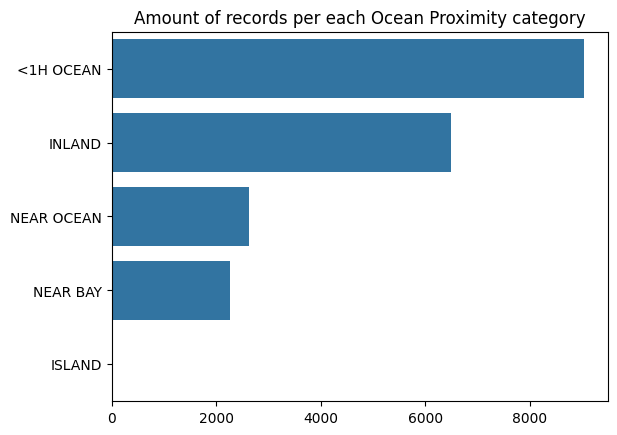

In [15]:
plt.figure()
sns.barplot(x=df_california_2["ocean_proximity"].value_counts().values, y=df_california_2["ocean_proximity"].value_counts().index)
plt.title("Amount of records per each Ocean Proximity category")
plt.ylabel("")
plt.show()

Here we have a different picture, `NEAR BAY` is the one with the less counts if we don´t take in consideration `ISLAND`.

We can see how different are each category from the other visually.

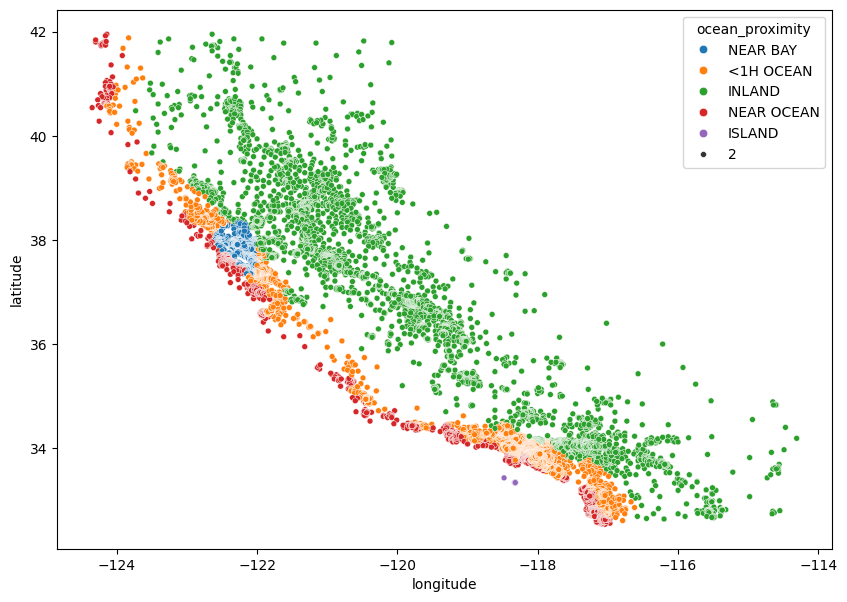

In [16]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_california_2, x="longitude", y="latitude", hue="ocean_proximity", size=2)
plt.show()

It has California's shape.

**INSIGHTS**:
- `INLAND` is very different from all the other categories in terms of their locations distribution, as it encompasses a bigger area of the state. That maybe make us think that this is not the best classification for the records.
- Is remarkable that `NEAR BAY` records are all of them concentrated in what we know is the bay of California, near San Francisco.
- There is other cluster of records in the south of the state, we can see that's what made the `1<H OCEAN` really boxplot really narrow and with a lot of outliers before. It is around the city of Los Angeles. A bit souther there is San Diego, which seems to also have a considerable amount of records.

So, big cities seems to have more records near them, that's something that sound reasonable. But we can also see that `ocean_proximity` may not be the bes way in which we can classificate our rows, since it has a really high variance.

We can try to colored this scatterplot by the houses prices.

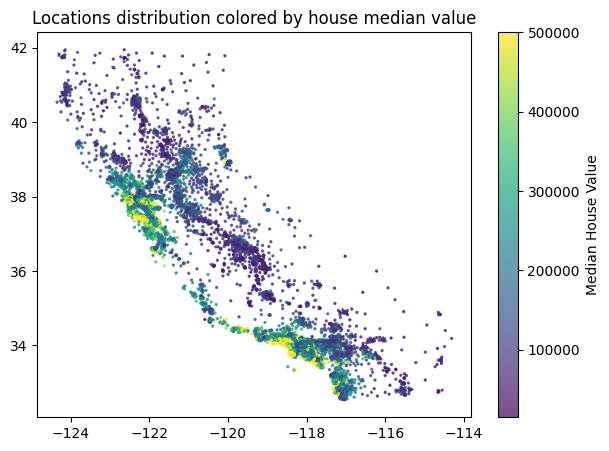

In [17]:
plt.figure(figsize=(7, 5))
scatter = plt.scatter(x=numerical_data["longitude"], y=numerical_data["latitude"], c=numerical_data["median_house_value"], s=2, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Median House Value")

plt.title("Locations distribution colored by house median value")
plt.show()

**INSIGHT**: The houses with the higher median value are distributed near the big metropolis that we mentioned before and the coast of California. The ones from the *interior* of the state tend to have lower values.

We can take a look to this kind of *clustering* distribution among our dataset with some histograms and density plots.

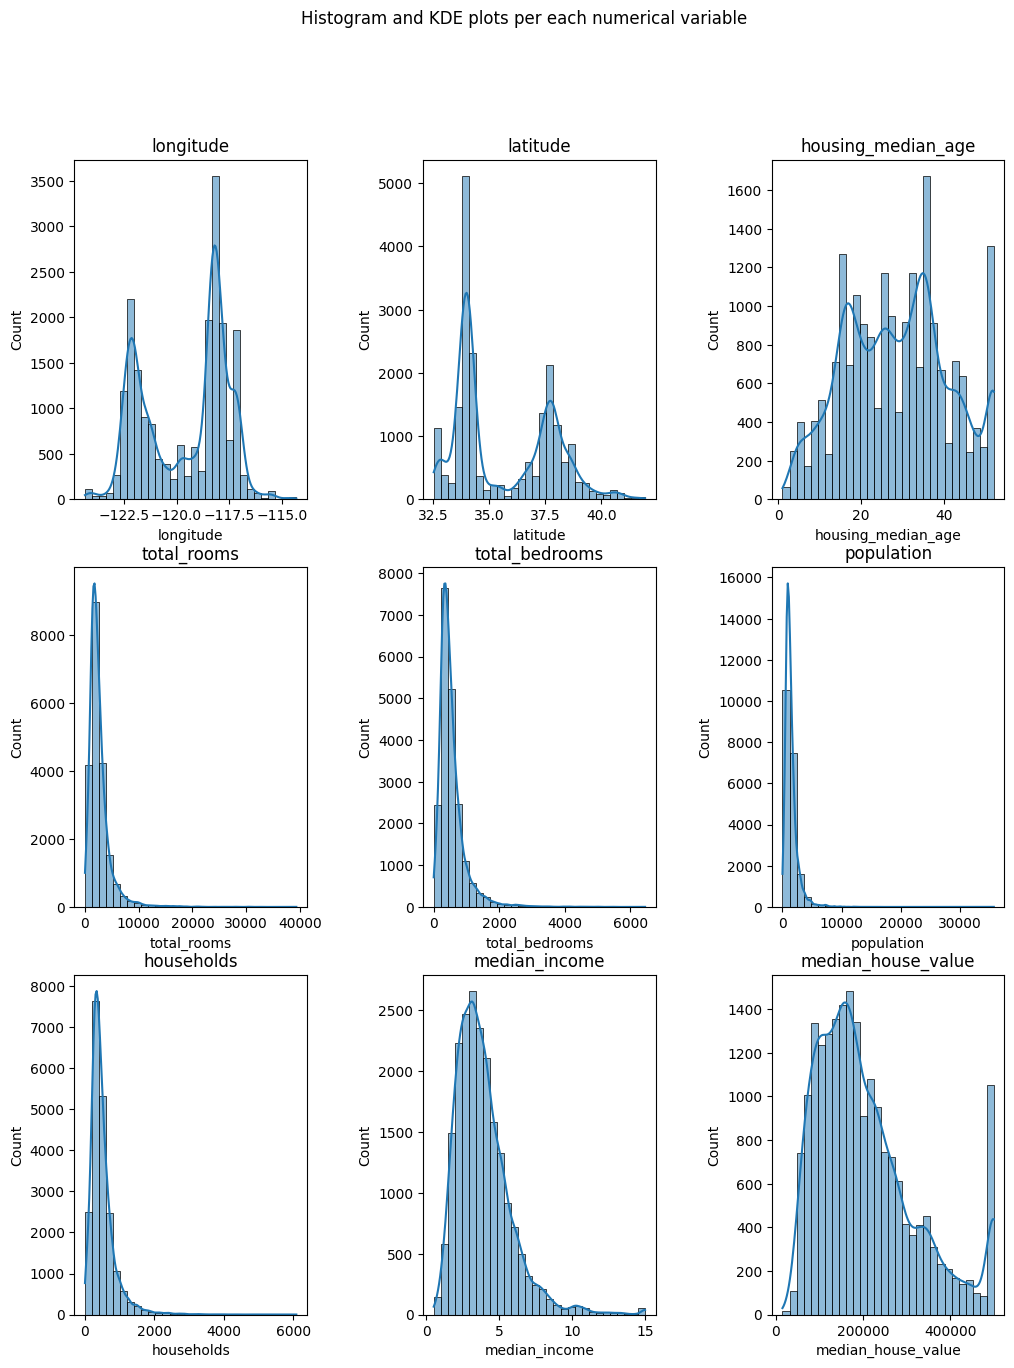

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 15))
ax = ax.flatten()
fig.subplots_adjust(wspace=0.5, hspace=0.2)

for i in range(0, len(cols)):
    variable = cols[i]
    variable_data = df_california_2[variable]

    sns.histplot(x=variable_data, kde=True, bins=30, ax=ax[i])

    ax[i].set_title(f'{variable}')

plt.suptitle("Histogram and KDE plots per each numerical variable")
plt.show()

The bimodal distribution is clear in the case of `latitude` and `longitude`.

For the other cases, it is centered to lower values within their min-max range. However, the `median_income` looks like if it has some relevant amount amount of higher values with that noticeable bar around 15.

This outlier-like records are more highlighted in `median_house_value`.

There are more like 1.000 record with median prices higher than 400.000

The `housing_median_age` looks the more chaotic.

**INSIGHT**: based on the coordinates and slightly less in the `median_house_values`, it looks like there are two hidden clusters.

But remembering that our goal is to predict the price of the house as a function of the rest of the variables, we should see how they are correlated.

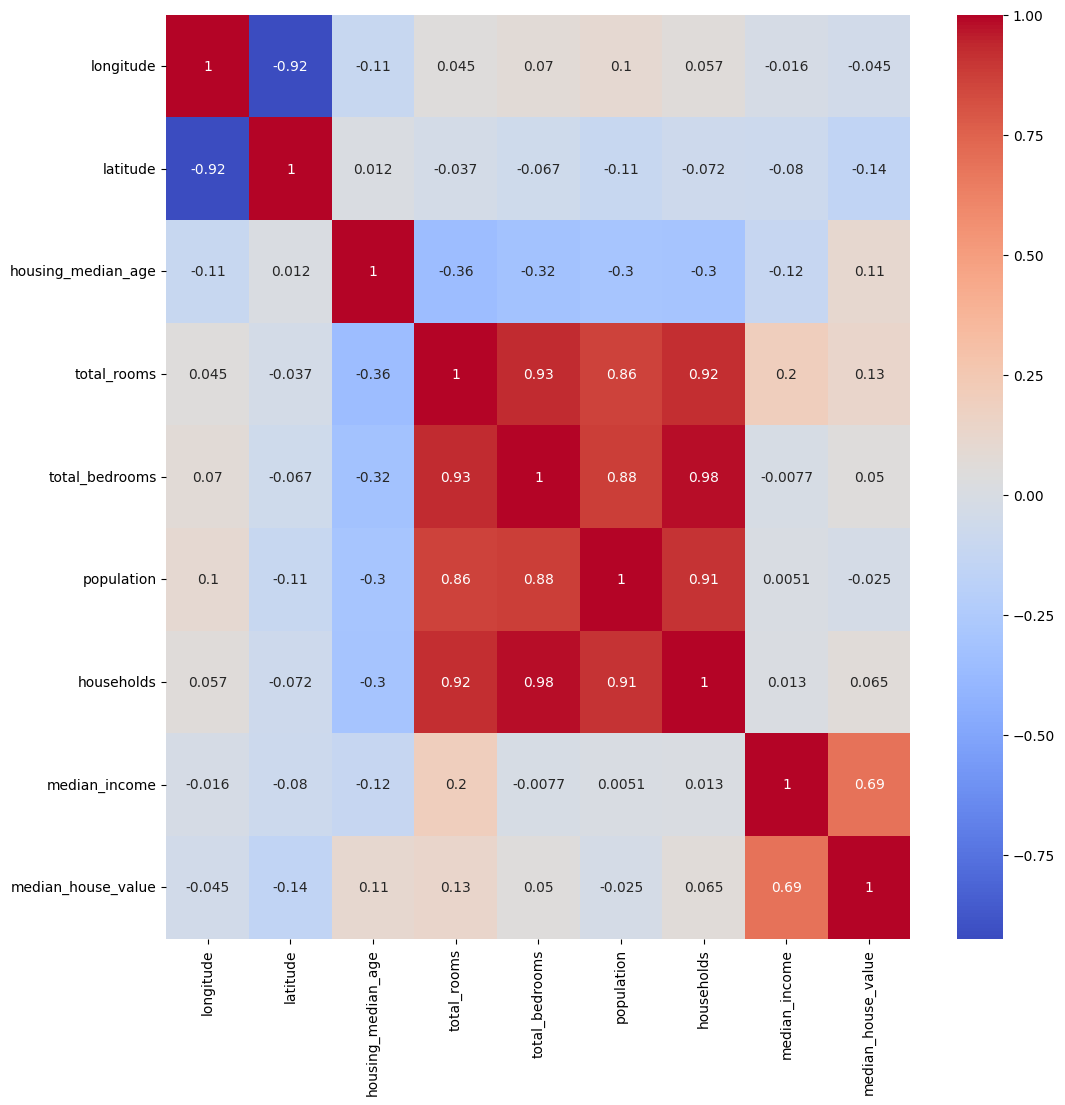

In [19]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=numerical_data.corr(), cmap="coolwarm", annot=True)
plt.show()

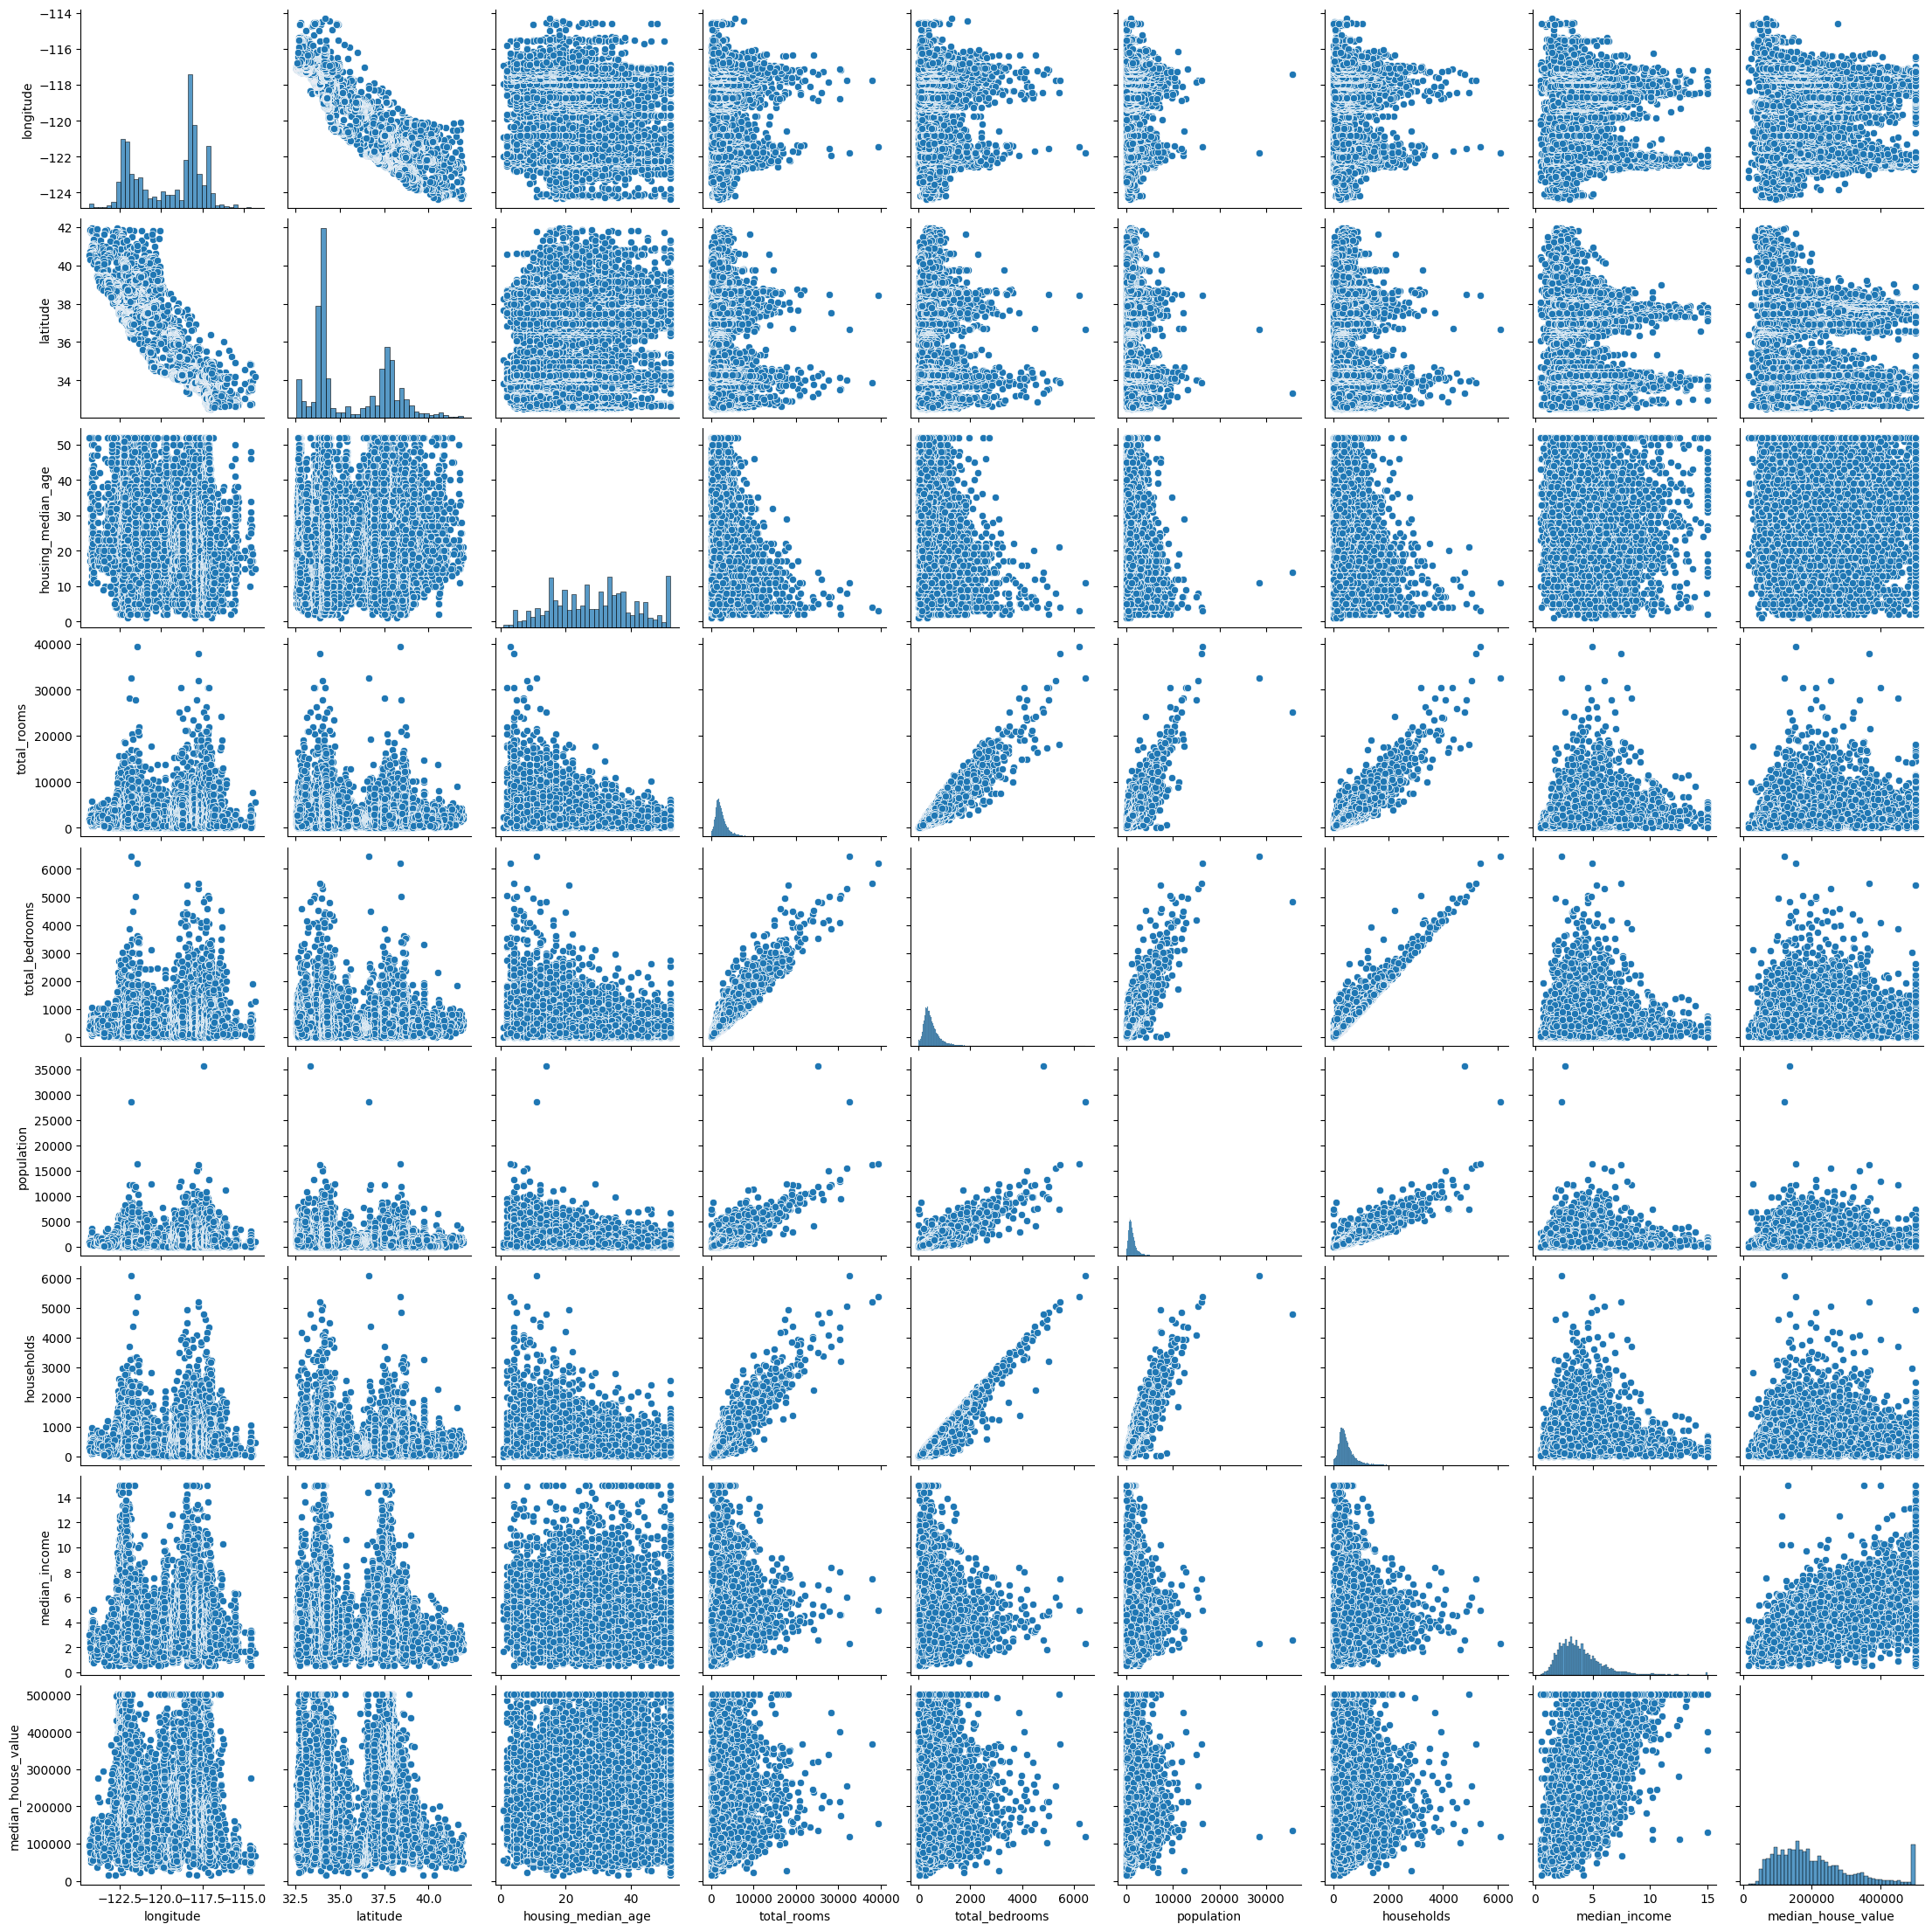

In [20]:
sns.pairplot(numerical_data)

This starts to look more interesting.

As we can see before, the `longitude` and `latitude` define two clusters, and here we can see that they are strongly negatively linear correlated.

We can see that our target variable, the `median_house_value` has a positive strong correlation with the `median_income`, it makes sense that the richer regions also have higher prices.

But also, there are lots of strong positive correlations between the `bedrooms` and `population` related variables, we can think that this is due to the fact that, as population increases, the needed of houses does so.

**INSIGHT**: different variables seems like tell us something about things that are strongly (linear) correlated, we may think of reduce the dimensions of our dataset.

### Dimensionality Reduction

It looks like some variables are redundant, and can be linear described as a function of others because of their strong Pearson correlation coeficient. We can apply an algorithm that can take advantage of this situation to get a different visualization of our dataset and look if the our hidden *cluster* suspect improves. That algorithm is `PCA`.

As it works with distances, we will need to normalize our values.

In [21]:
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

In [22]:
n_components = 9

pca = PCA(n_components=n_components)
pca.fit_transform(numerical_data_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()


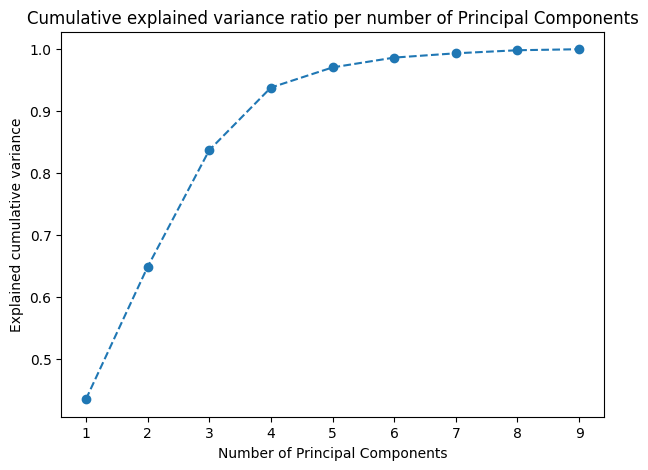

In [23]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative explained variance ratio per number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained cumulative variance')
plt.show()

We can see that with just three PC we can explain almost 85% of the variance. That's a really high ratio, and also a good number for visualization, since we can do a 3D scatterplot.

In [24]:
pca = PCA(n_components=3)
numerical_data_pca = pca.fit_transform(numerical_data_scaled)

In [25]:
numerical_data_pca

array([[-1.96781667,  0.54460165,  3.59326044],
       [ 3.01546914,  1.3071318 ,  2.88792402],
       [-1.88826505,  0.85002648,  2.67367899],
       ...,
       [-0.51134524,  2.11680388, -1.02660343],
       [-0.9242834 ,  2.09630871, -0.97933496],
       [ 0.07847097,  2.11500363, -0.83026998]])

In [26]:
def pca_data_scatterpot(pca_data=numerical_data_pca, elev=0, azim=0):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
       pca_data[:, 0],
       pca_data[:, 1],
       pca_data[:, 2],
    )

    ax.view_init(elev=elev, azim=azim)


    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

    plt.title('Scatterplot 3D of Principal Components by Ocean Proximity')
    plt.show()

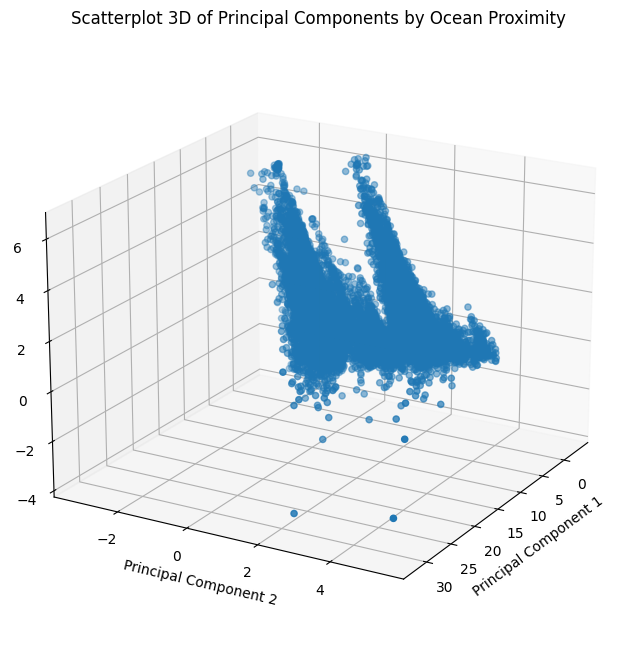

In [27]:
pca_data_scatterpot(elev=20, azim=30)

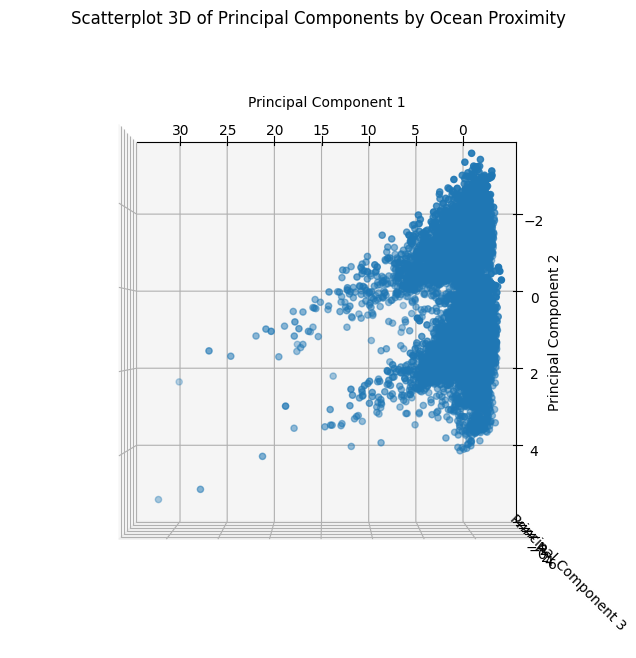

In [28]:
pca_data_scatterpot(elev=90, azim=90)

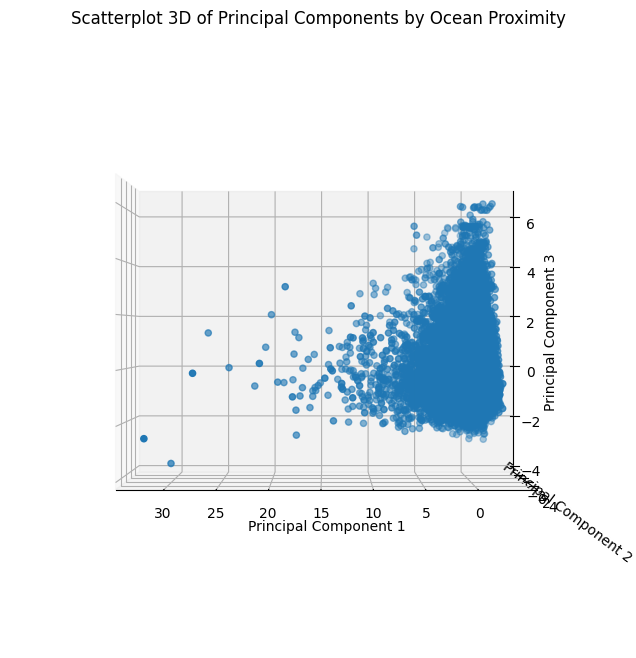

In [29]:
pca_data_scatterpot(elev=0, azim=90)

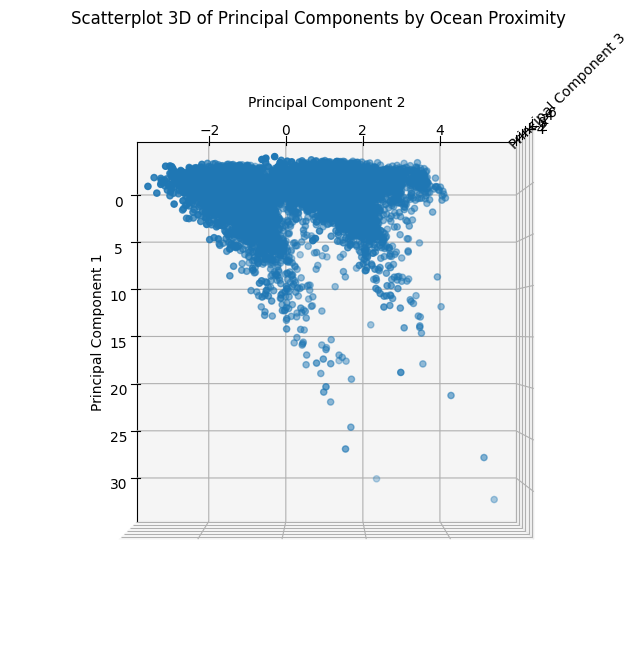

In [30]:
pca_data_scatterpot(elev=90, azim=0)

It looks like there are, at least, two different clusters that are connected in some way.

They are not as separated as we may wanted.

**INSIGHT**: There are two easy distinguible clusters. However, they are really close to each other, and they have an area of contact.

### Clustering

The last insight may be crucial for our algorithm selection to get new labels for this dataset.

Our initial EDA and now the PCA dimension reduction shows strong evidence in favor that there are two different clusters hidden in our datasets. However, due to the the previous observation, we can think that the best option will be an algorithm based on *density* to discriminate different groups.

Because of this, we will use `DBSCAN` as our cluster algorithm, since it can handle this *strange* forms well.

Anyways, because we have strong evidence that the amount of correct clusters is 2, we will also try `KMeans` and use its metrics score as a lower limit to select the `DBSCAN` hyperparameters, if it is the case that we find a better density based algorithm.

#### K-Means

In [31]:
k_values = range(2, 10)

inertia_scores = []
silhouette_scores = []

for k in k_values:
    #the random state is just to make this notebook always have the same result
    kmeans = KMeans(n_clusters = k, random_state=42)
    clusters = kmeans.fit_predict(numerical_data_pca)

    silhouette_avg_score = silhouette_score(numerical_data_pca, clusters)

    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_avg_score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

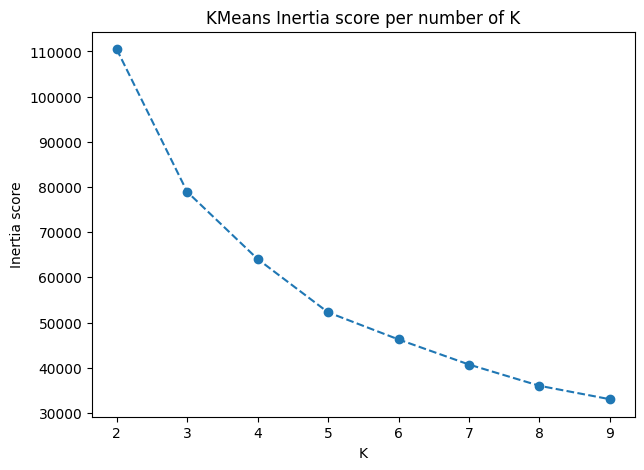

In [32]:
plt.figure(figsize=(7, 5))
plt.plot(k_values, inertia_scores, marker='o', linestyle='--')
plt.title('KMeans Inertia score per number of K')
plt.xlabel('K')
plt.ylabel('Inertia score')
plt.show()

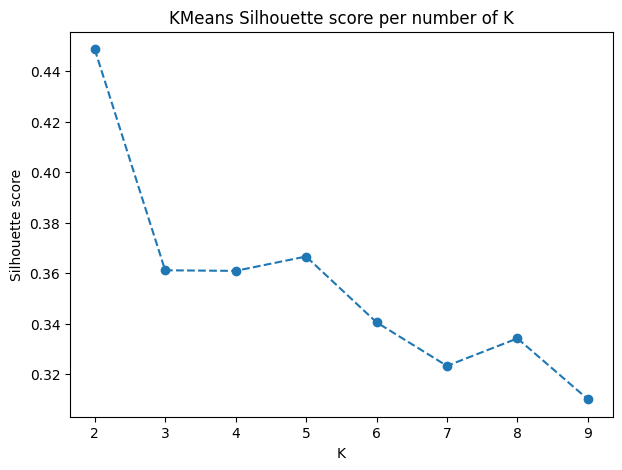

In [33]:
plt.figure(figsize=(7, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title('KMeans Silhouette score per number of K')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

In [34]:
kmeans = KMeans(n_clusters=2)
kmeans_clusters = kmeans.fit_predict(numerical_data_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
kmeans_series = pd.Series(kmeans_clusters)
kmeans_series.value_counts()

0    18056
1     2377
dtype: int64

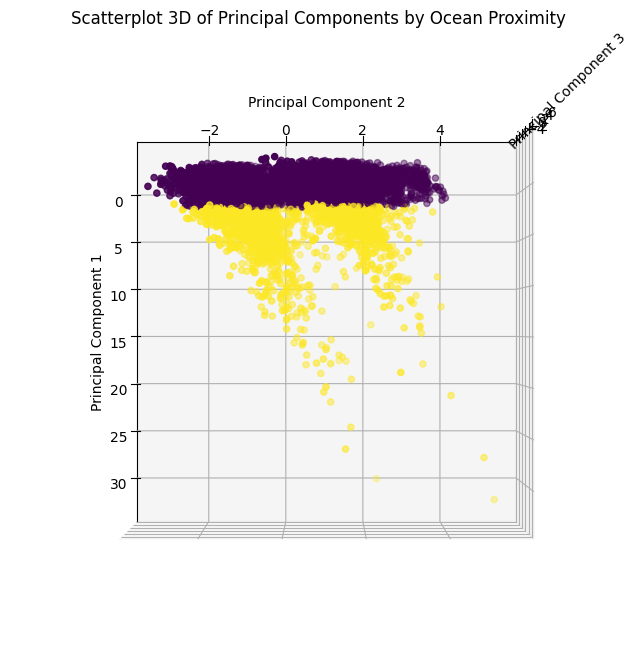

In [36]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    numerical_data_pca[:, 0],
    numerical_data_pca[:, 1],
    numerical_data_pca[:, 2],
    c=kmeans_clusters
)

ax.view_init(elev=90, azim=0)


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.title('Scatterplot 3D of Principal Components by Ocean Proximity')
plt.show()

Based on the `Inertia` score, which is defined as the mean squared distance between each data point and its closest centroid, we are not able to select an optimal number for $K$, since there is no local minimum to apply the *elbow rule*.

However, for the `Silhouette` one, which tells us how well classified are our data points (and we want to maximize it then), the best value is about `0.45` for $K = 2$.

It is not a lot, but we can use it as a minimum for our

#### DBSCAN

In [37]:
epsilons = [0.0001, 0.001, 0.01, 0.1, 1]
min_neighbors = [3, 5, 7, 11, 13, 17]

epsilon_neighbors_pairs = []
silhouette_scores = []


for e in epsilons:
    for n in min_neighbors:

        pair = (e, n)

        dbscan = DBSCAN(eps=e, min_samples=n)
        clusters = dbscan.fit_predict(numerical_data_pca)

        # In case there is some pair that returns only one cluster
        try:
            silhouette_avg_score = silhouette_score(numerical_data_pca, clusters)
        except:
            silhouette_avg_score = 0

        epsilon_neighbors_pairs.append(pair)
        silhouette_scores.append(silhouette_avg_score)

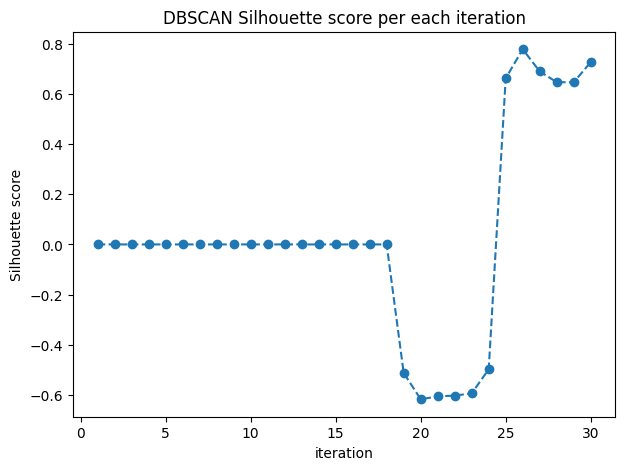

In [38]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(silhouette_scores)+1), silhouette_scores, marker='o', linestyle='--')
plt.title('DBSCAN Silhouette score per each iteration')
plt.xlabel('iteration')
plt.ylabel('Silhouette score')
plt.show()

The best Silhouette Score was got something about the 25 iterations, and it is almost 0.80

In [39]:
silhouette_scores[24:]

[0.6630738817356,
 0.7792415656777791,
 0.6906342087357458,
 0.6475528478122673,
 0.6473499464566684,
 0.7278182976580447]

In [40]:
epsilon_neighbors_pairs[24:]

[(1, 3), (1, 5), (1, 7), (1, 11), (1, 13), (1, 17)]

It corresponds to the `25` index pair in the pairs array.

In [41]:
best_hyperparameters = epsilon_neighbors_pairs[25] #(1, 5)

In [42]:
e , n = best_hyperparameters
dbscan = DBSCAN(eps=e, min_samples=n)
dbscan_clusters = dbscan.fit_predict(numerical_data_pca)

In [43]:
dbscan_series = pd.Series(dbscan_clusters)

In [44]:
dbscan_series.value_counts()

 0    20372
-1       53
 1        8
dtype: int64

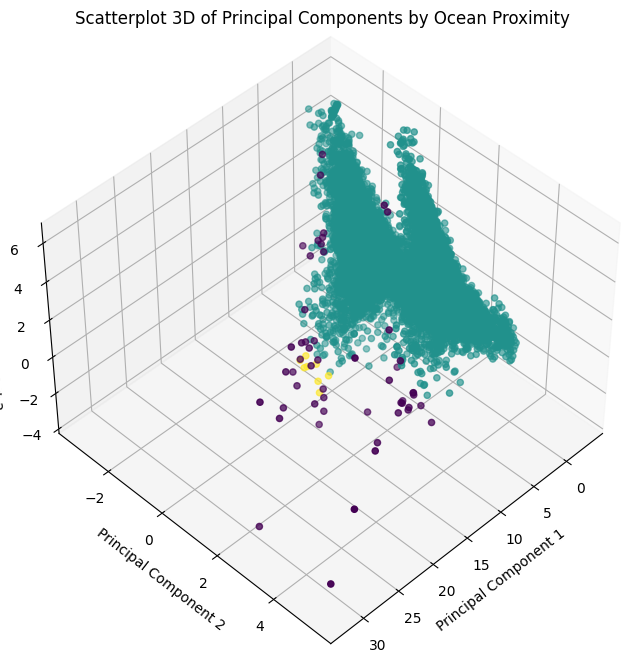

In [45]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    numerical_data_pca[:, 0],
    numerical_data_pca[:, 1],
    numerical_data_pca[:, 2],
    c=dbscan_clusters
)

ax.view_init(elev=45, azim=45)


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.title('Scatterplot 3D of Principal Components by Ocean Proximity')
plt.show()

Doesn´t seem like a good separation, even if it doubled the previous silhouette score.

Almost all of the data is part of the same cluster, which is not really informative.

### Clustering Selection

Because of this non-informative contribution of the DBSCAN, we may think of going with KMeans this time, since it gives us more information, and the proportion of 18.000 - 2.000 records that it gave us for the clusters may even make sense considering that there were a lot of values really concentrated for each variable and also a lot of outliers with higher values for each of them.

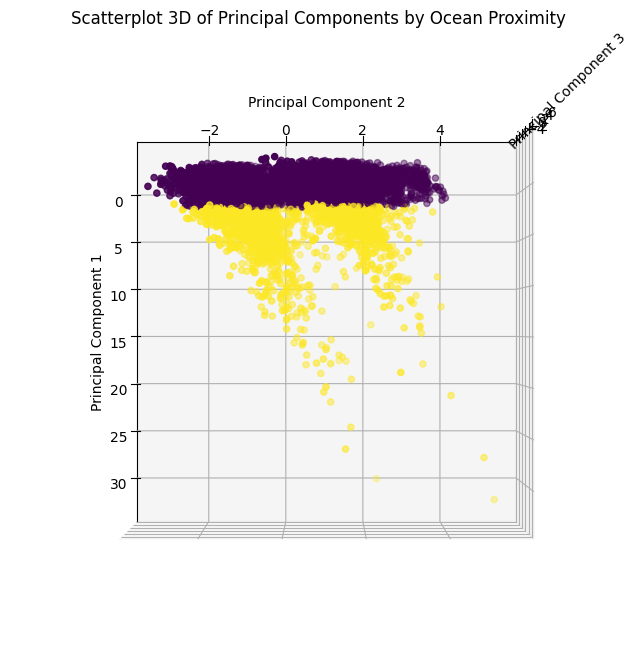

In [46]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    numerical_data_pca[:, 0],
    numerical_data_pca[:, 1],
    numerical_data_pca[:, 2],
    c=kmeans_clusters
)

ax.view_init(elev=90, azim=0)


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.title('Scatterplot 3D of Principal Components by Ocean Proximity')
plt.show()

Here that's what we have, some really concentrated values and the others that go away (in the same direction) from them.

In [47]:
df_california_2["cluster"] = kmeans_series

<ipython-input-47-ce4bdc570dcf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_california_2["cluster"] = kmeans_series


In [48]:
df_california_2

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

      ocean_proximity  cluster  
0            NEAR BAY      0.0  
1            NEAR BAY      1.0  
2            NEAR BAY      0.0  
3            NEAR BAY      0.0  
4            NEAR BAY      0.0  
...               ...      ...  
20635          INLAND      NaN  
20636          INLAND      NaN  
20637          INLAND      NaN  
20638          INLAND      NaN  
20639          INLAND      NaN  

[20433 rows x 11 columns]

However, in the previous EDA we saw that our target variable is really well correlated with `median_income` (0.69 Pearson coefficient) and `latitude`-`longitude` as a pair (scatterplot coloured by house price).

 Can we get a better clustering only based on these three variables?

### Selected variables based clustering

In [49]:
selected_data = numerical_data[["latitude", "longitude", "median_income"]]

In [50]:
scaler = StandardScaler()
selected_data_scaled = scaler.fit_transform(selected_data)

In [51]:
k_values = range(2, 15)

inertia_scores = []
silhouette_scores = []

for k in k_values:
    #the random state is just to make this notebook always have the same result
    kmeans = KMeans(n_clusters = k, random_state=42)
    clusters = kmeans.fit_predict(selected_data)

    silhouette_avg_score = silhouette_score(selected_data_scaled, clusters)

    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_avg_score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

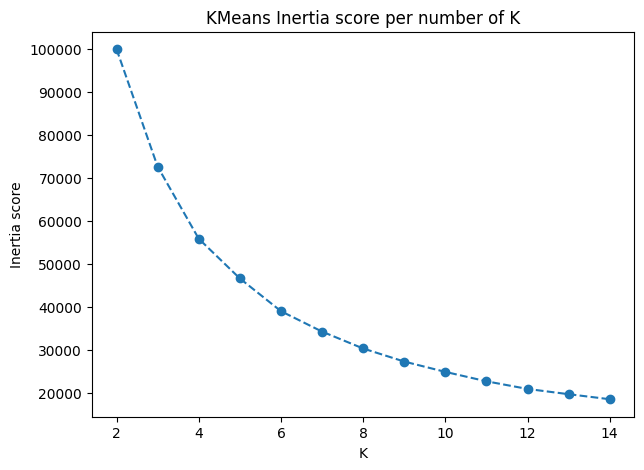

In [52]:
plt.figure(figsize=(7, 5))
plt.plot(k_values, inertia_scores, marker='o', linestyle='--')
plt.title('KMeans Inertia score per number of K')
plt.xlabel('K')
plt.ylabel('Inertia score')
plt.show()

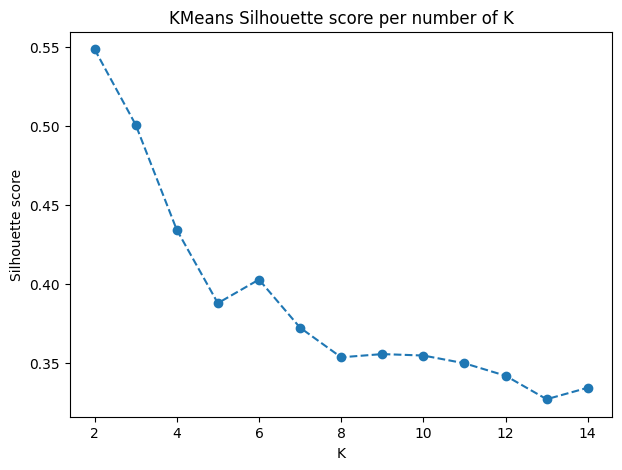

In [53]:
plt.figure(figsize=(7, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title('KMeans Silhouette score per number of K')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

We get the best silhouette with 2 clusters. There is no clear elbow for the inertia.

However, both metrics have better values in this KMeans than in the previous one.

In [54]:
kmeans = KMeans(n_clusters=2, random_state=42)
selected_data_clusters = kmeans.fit_predict(selected_data_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [55]:
selected_data_clusters

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

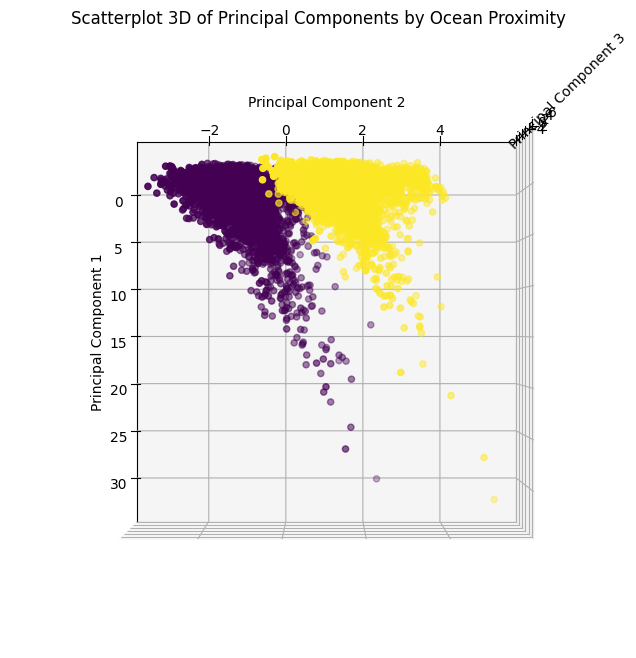

In [56]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    numerical_data_pca[:, 0],
    numerical_data_pca[:, 1],
    numerical_data_pca[:, 2],
    c=selected_data_clusters
)

ax.view_init(elev=90, azim=0)


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.title('Scatterplot 3D of Principal Components by Ocean Proximity')
plt.show()

Labelling the `PCA` components by these selected variables, we get something that makes more sense visually.

In [57]:
kmeans_series = pd.Series(selected_data_clusters)

In [58]:
kmeans_series.value_counts()

0    11812
1     8621
dtype: int64

The clusters are even better balanced.

We will continue with this labels.

In [59]:
df_california_2["cluster"] = kmeans_series

<ipython-input-59-ce4bdc570dcf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_california_2["cluster"] = kmeans_series


### Post-clustering Analysis

In [60]:
df_california_2["cluster"].value_counts()

0.0    11686
1.0     8542
Name: cluster, dtype: int64

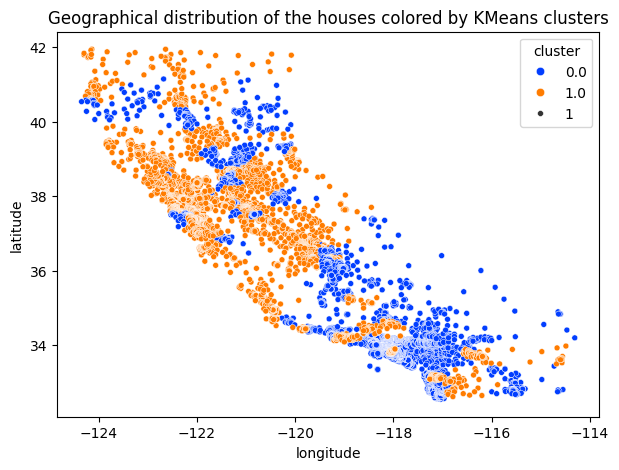

In [61]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_california_2, x="longitude", y="latitude", hue="cluster", size=1, palette="bright")
plt.title("Geographical distribution of the houses colored by KMeans clusters")
plt.show()

It doesn´t seem like it captures anything geographical about the data.

In [62]:
df_cluster_0 = df_california_2.query("cluster == 0")
df_cluster_1 = df_california_2.query("cluster == 1")

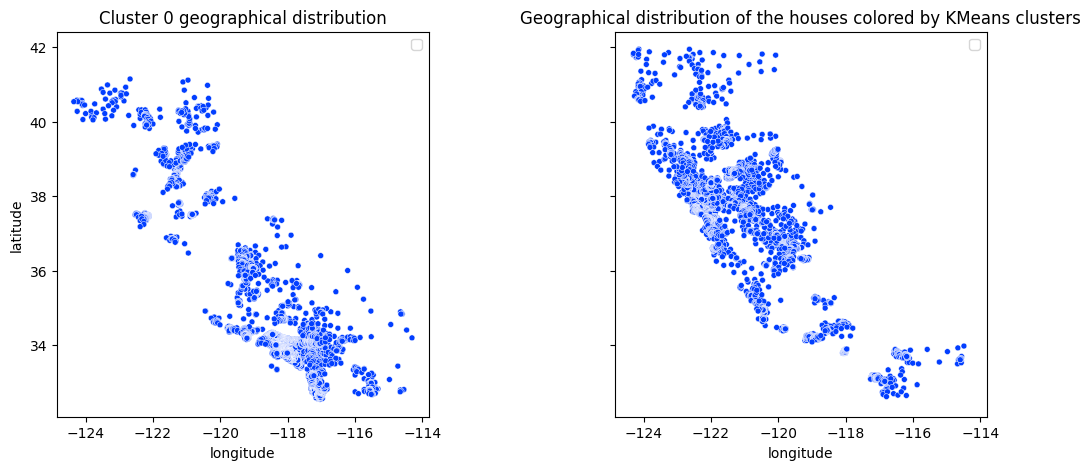

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex="row", sharey="row", figsize=(12,5))
ax = ax.flatten()
fig.subplots_adjust(wspace=0.5)
sns.scatterplot(data=df_cluster_0, x="longitude", y="latitude", hue="cluster", size=1, ax=ax[0], palette="bright")
ax[0].set_title("Cluster 0 geographical distribution")
ax[0].legend("")
sns.scatterplot(data=df_cluster_1, x="longitude", y="latitude", hue="cluster", size=1, ax=ax[1], palette="bright")
ax[1].set_title("Cluster 1 geographical distribution")
ax[1].legend("")
plt.title("Geographical distribution of the houses colored by KMeans clusters")
plt.show()

Looks like the `0` type of houses are a bit more concentrated over Los Angeles and San Diego big cities (in the south of the state), while the `1` ones have a bit more proximity to San Francisco bay.

We can try again to see each boxplot per category.

<ipython-input-64-a88052270c26>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["cluster"], palette="bright")
<ipython-input-64-a88052270c26>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["cluster"], palette="bright")
<ipython-input-64-a88052270c26>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["cluster"], palette="bright")
<ipython-input-64-a88052270c26>:10: FutureWarning: 

Passing `palette`

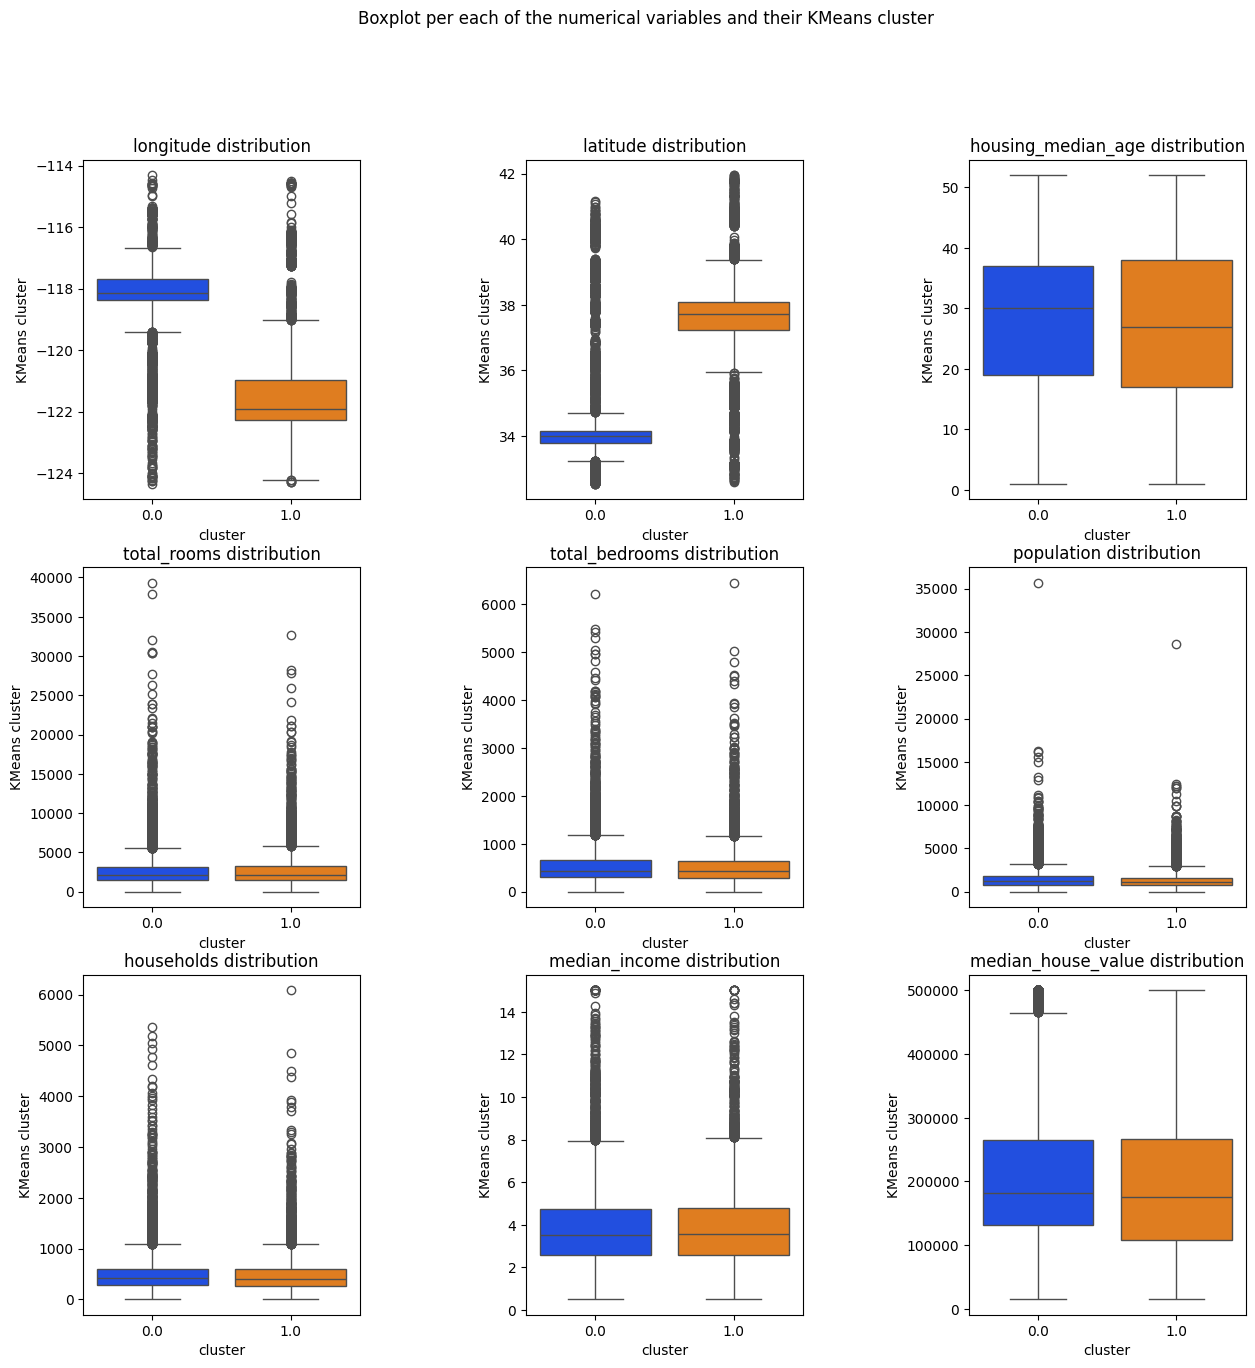

In [64]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=None, sharey=None, figsize=(15, 15))
ax = ax.flatten()
fig.subplots_adjust(wspace=0.6, hspace=0.2)

for i in range(0, len(cols)):

    variable = cols[i]
    variable_data = numerical_data[variable]

    sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["cluster"], palette="bright")

    ax[i].set_title(f"{variable} distribution")
    ax[i].set_ylabel("KMeans cluster")



plt.suptitle("Boxplot per each of the numerical variables and their KMeans cluster")
plt.show()

It didn´t improve. The boxplots are almost the same as before. The assimetry in the `longitude` and `latitude` is just because of the distribution that we just observed.

We can see that the `0` labeled ones have a bit more ouliers than the `1` cluster, but that's because of the difference in size per each one.

The ML clustering algorithms that we tried didn´t work really well in order to give us better insights based on the labeled distribution of our variables.

The trend of `total_rooms`, `total_bedrooms`, `population_distribution`, `househoulds`, `median_income_distribution` to have a lot of values far away from the IQR persists. Also, we didn´t get anything really relevant about how our tartget variable `median_house_income` changes within each cluster, since the boxplot distribution is almost the same.

However, we can try a manual clustering using this variables.

### Outliers Clustering

#### By Median House Value

In [65]:
def get_IQR_outliers_count(df, variable):
    selected_variable = df[variable]

    quantile_25 = selected_variable.quantile(0.25)
    quantile_75 = selected_variable.quantile(0.75)
    IQR = quantile_75 - quantile_25

    non_outlier_top = quantile_75 + 1.5 * IQR
    non_outlier_bottom = quantile_25 - 1.5 * IQR

    outliers_count = np.sum((selected_variable > non_outlier_top) | (selected_variable < non_outlier_bottom))

    return outliers_count


In [66]:
numerical_cols = numerical_data.columns

In [67]:
for col in numerical_cols:
    outlier_count = get_IQR_outliers_count(df_california_2, col)
    print(f'{col} has {outlier_count} outliers')
    print('--------------------------------')

longitude has 0 outliers
--------------------------------
latitude has 0 outliers
--------------------------------
housing_median_age has 0 outliers
--------------------------------
total_rooms has 1290 outliers
--------------------------------
total_bedrooms has 1271 outliers
--------------------------------
population has 1190 outliers
--------------------------------
households has 1210 outliers
--------------------------------
median_income has 670 outliers
--------------------------------
median_house_value has 1064 outliers
--------------------------------


The `population` or `bedroom` related variables have a similar amount of outliers, something that we could have expected since they are all highly correlated. It is more interesting that even `median_house_value` has more than 1.000, but seeing the boxplot they didn´t really are that far away from the IQR.

We are going to take this as our criteria to split our dataframe and see if we can get something better.

In [68]:
price_quantile_25 = df_california_2["median_house_value"].quantile(0.25)
price_quantile_75 = df_california_2["median_house_value"].quantile(0.75)

IQR = quantile_75 - quantile_25

non_outlier_top = quantile_75 + 1.5 * IQR
non_outlier_bottom = quantile_25 - 1.5 * IQR

outliers = (df_california_2["median_house_value"] > non_outlier_top) | (df_california_2["median_house_value"] < non_outlier_bottom)

In [69]:
np.sum(outliers)

1064

In [70]:
df_california_2["is_outlier"] = outliers

<ipython-input-70-9372fe415814>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_california_2["is_outlier"] = outliers


Now we can see if we are able to get some useful insight.

<ipython-input-71-59f8eb50b97e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["is_outlier"], palette="bright")
<ipython-input-71-59f8eb50b97e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["is_outlier"], palette="bright")
<ipython-input-71-59f8eb50b97e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["is_outlier"], palette="bright")
<ipython-input-71-59f8eb50b97e>:10: FutureWarning: 

Passing 

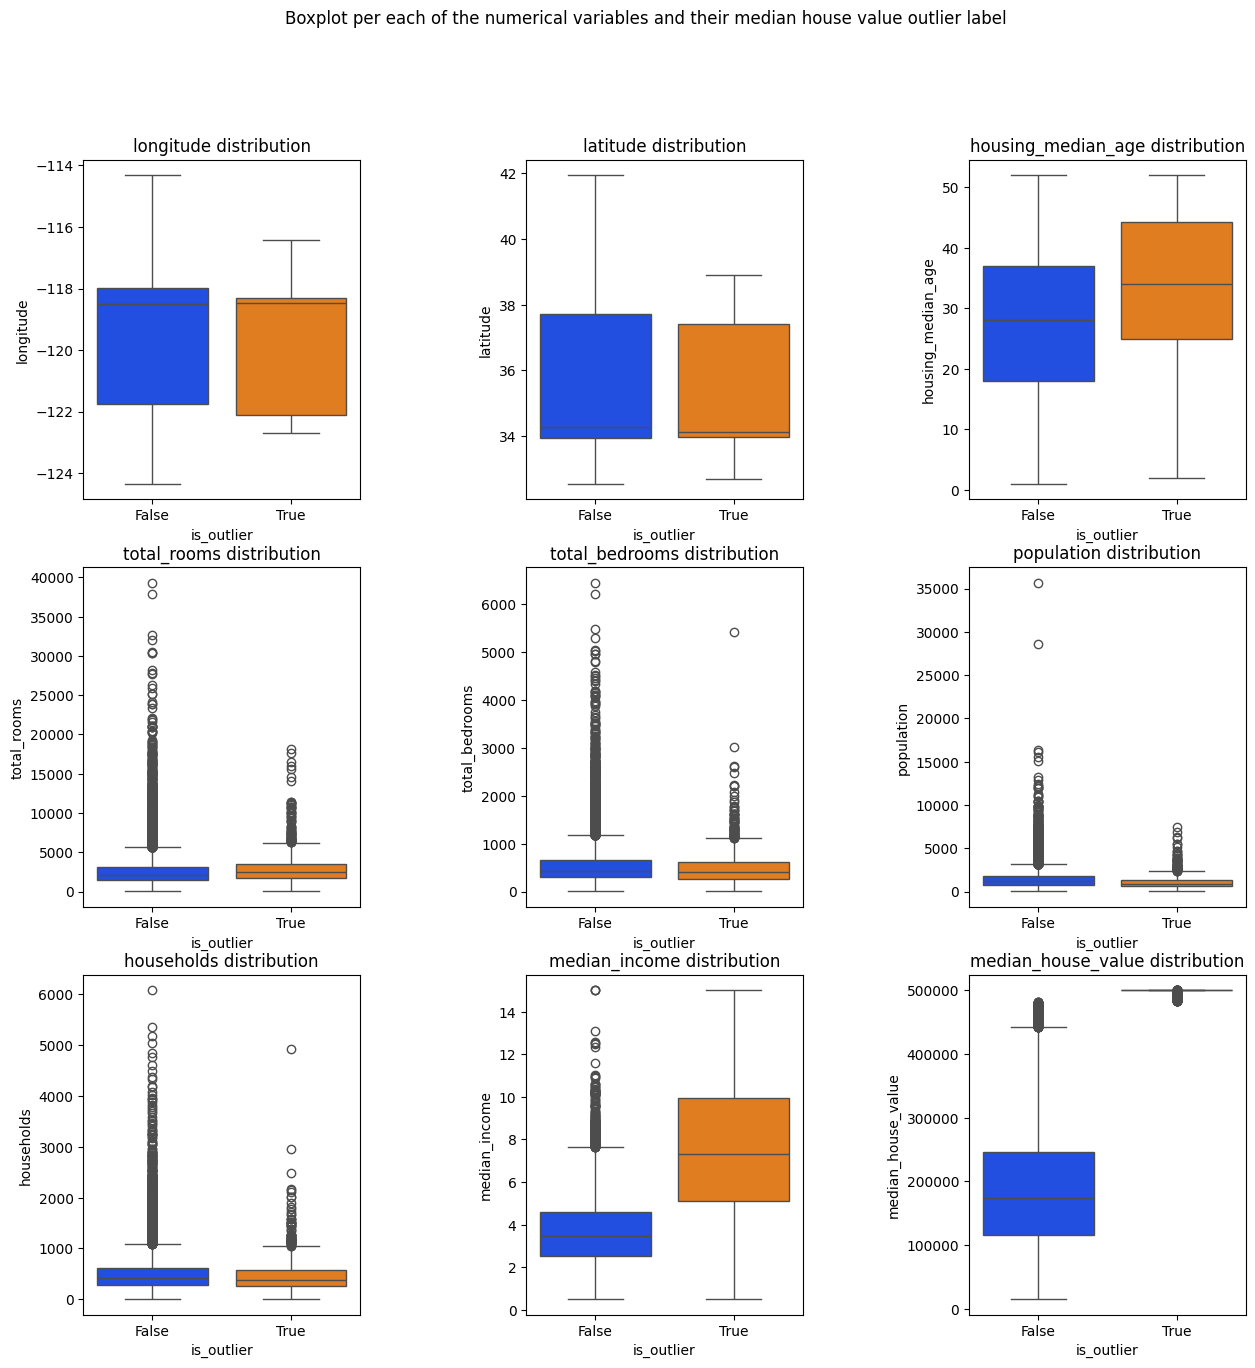

In [71]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=None, sharey=None, figsize=(15, 15))
ax = ax.flatten()
fig.subplots_adjust(wspace=0.6, hspace=0.2)

for i in range(0, len(cols)):

    variable = cols[i]
    variable_data = numerical_data[variable]

    sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["is_outlier"], palette="bright")

    ax[i].set_title(f"{variable} distribution")



plt.suptitle("Boxplot per each of the numerical variables and their median house value outlier label")
plt.show()

We used as a criteria the `median_house_value` to label our dataframe, so that boxplot is not really representative for us.

The `median_income_distribution` looks like it follows the trend of higher values for the outliers. But we can also see that similar thing happens with `housing_median_age`.

The rest of the variables didn´t really improve.

**INSIGHT**: the higher price houses are correlated with higher median age and income.

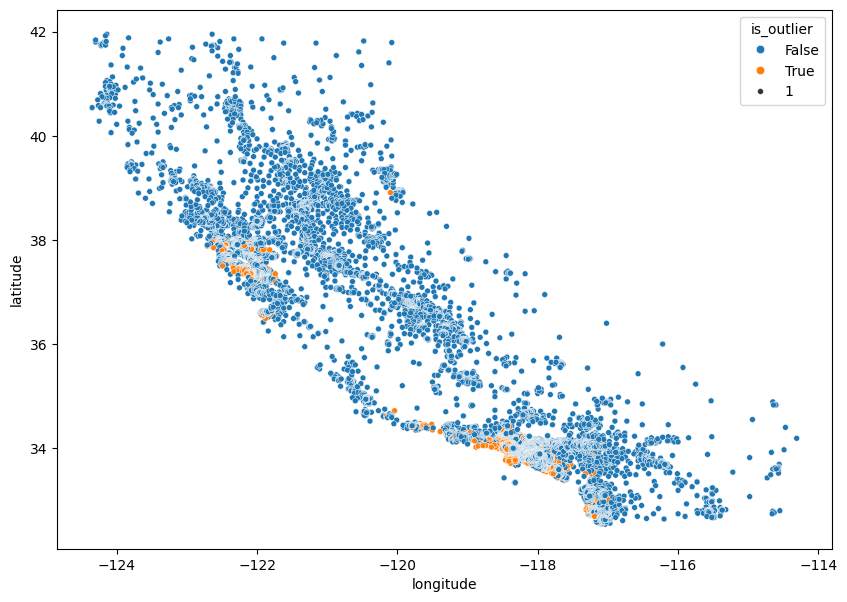

In [72]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_california_2, x="longitude", y="latitude", hue="is_outlier", size=1)
plt.show()

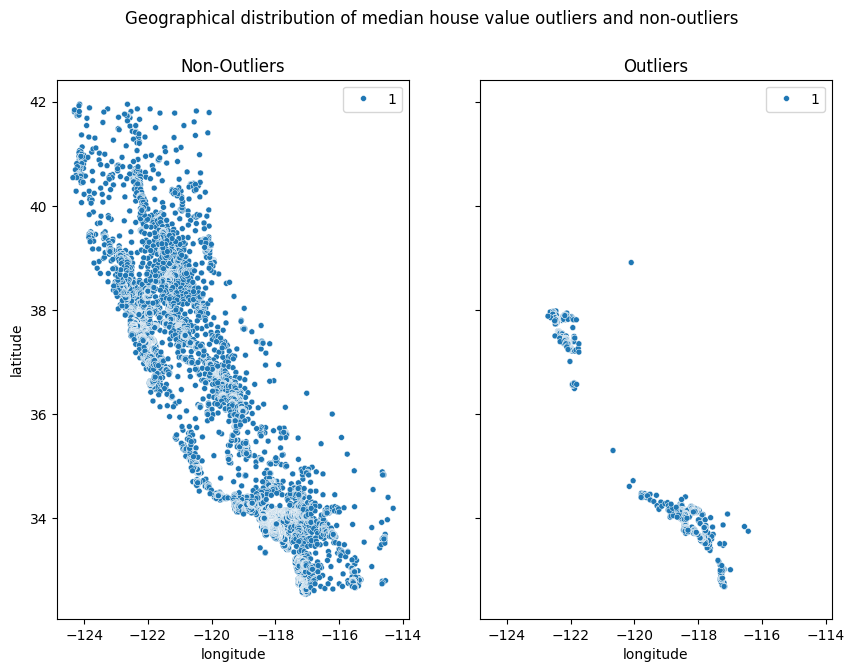

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex="row", sharey="row", figsize=(10,7))
ax = ax.flatten()
sns.scatterplot(data=df_california_2.query("is_outlier == False"), x="longitude", y="latitude", size=1, ax=ax[0])
ax[0].set_title("Non-Outliers")
sns.scatterplot(data=df_california_2.query("is_outlier == True"), x="longitude", y="latitude", size=1, ax=ax[1])
ax[1].set_title("Outliers")
plt.suptitle("Geographical distribution of median house value outliers and non-outliers")
plt.show()

The outliers are almost all concentrated around the big metropolis that we have been mentioned over this notebook.

However, there are non-outliers that are proximate to them, and they are not a few. It is not enough to say that the big cities houses are all in other cluster than the rest of the houses.

#### By Total Rooms

Because of the high correlation between the other big size outliers variables, it shouldn't be really important which of them we choose to label the DataFrame, they all have almost the same amount IQR based ones.

Here we are taking the `total_rooms` because it is the one that has slightly more than the rest.

In [74]:
rooms_quantile_25 = df_california_2["total_rooms"].quantile(0.25)
rooms_quantile_75 = df_california_2["total_rooms"].quantile(0.75)

IQR = rooms_quantile_75 - rooms_quantile_25

non_outlier_top = rooms_quantile_75 + 1.5 * IQR
non_outlier_bottom = rooms_quantile_25 - 1.5 * IQR

rooms_outliers = (df_california_2["total_rooms"] > non_outlier_top) | (df_california_2["total_rooms"] < non_outlier_bottom)

In [75]:
np.sum(rooms_outliers)

1290

In [76]:
df_california_2["is_rooms_outlier"] = rooms_outliers

<ipython-input-76-dd016b2e233e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_california_2["is_rooms_outlier"] = rooms_outliers


<ipython-input-77-3983a139a2d5>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["is_rooms_outlier"], palette="bright")
<ipython-input-77-3983a139a2d5>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["is_rooms_outlier"], palette="bright")
<ipython-input-77-3983a139a2d5>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["is_rooms_outlier"], palette="bright")
<ipython-input-77-3983a139a2d5>:10: FutureW

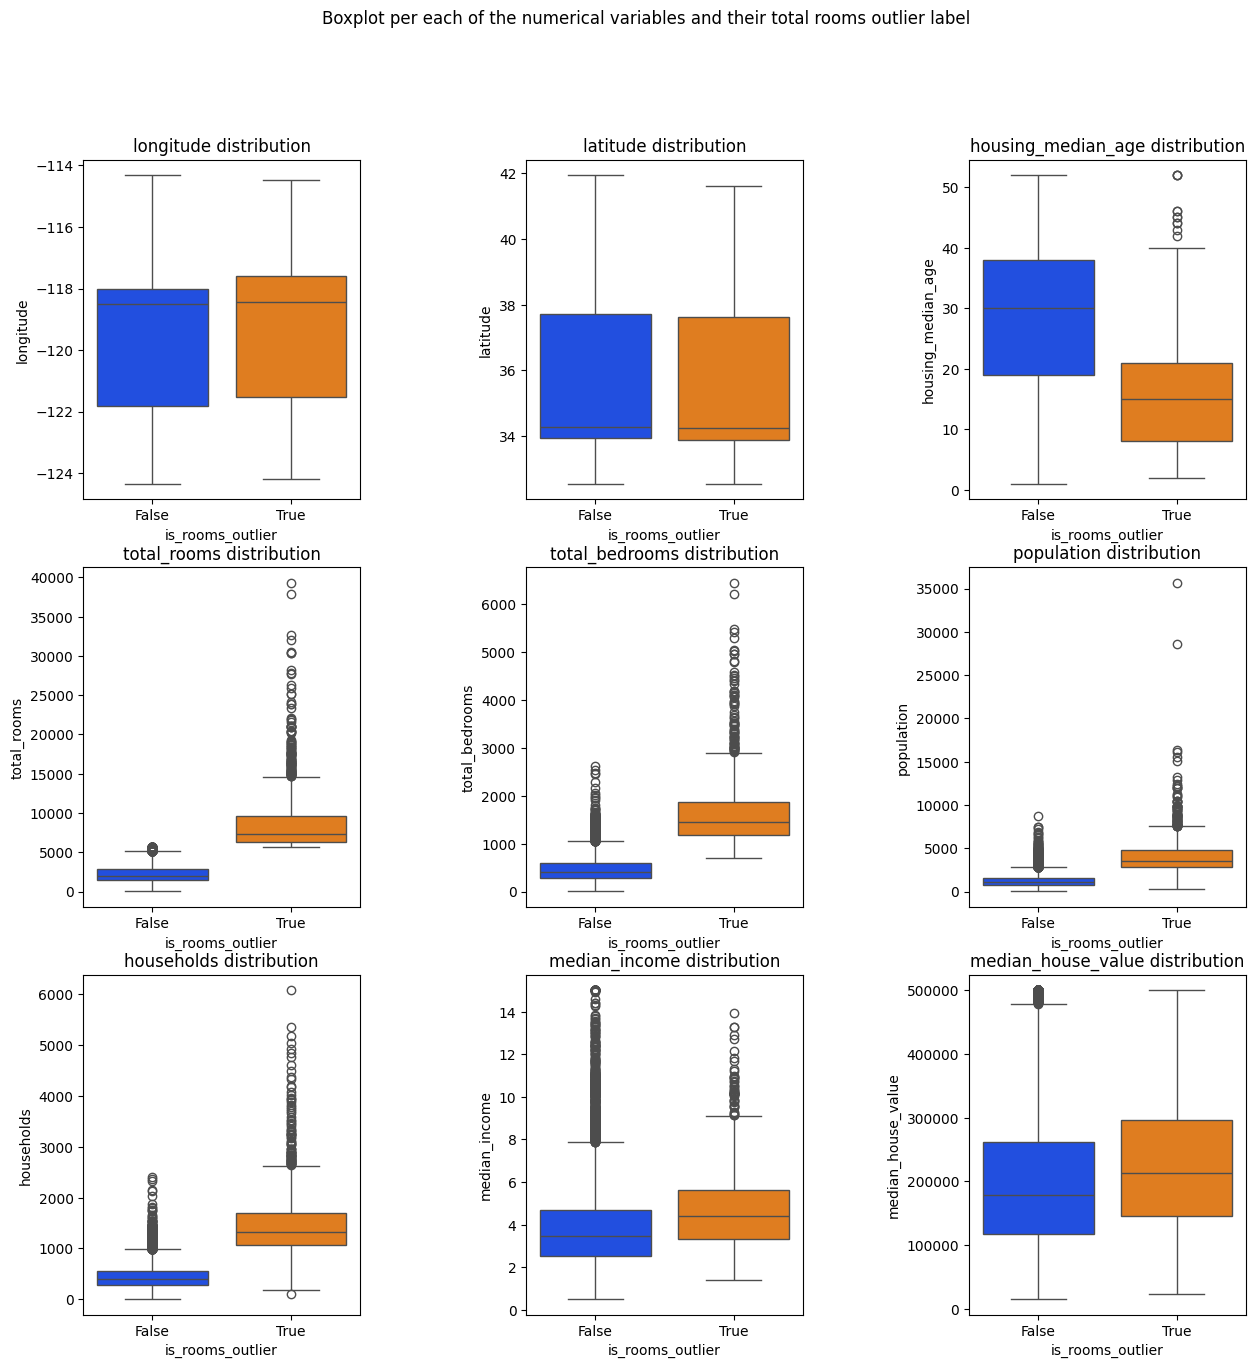

In [77]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=None, sharey=None, figsize=(15, 15))
ax = ax.flatten()
fig.subplots_adjust(wspace=0.6, hspace=0.2)

for i in range(0, len(cols)):

    variable = cols[i]
    variable_data = numerical_data[variable]

    sns.boxplot(y = variable_data, ax=ax[i], x=df_california_2["is_rooms_outlier"], palette="bright")

    ax[i].set_title(f"{variable} distribution")



plt.suptitle("Boxplot per each of the numerical variables and their total rooms outlier label")
plt.show()

Nothing really interesting in relation to our target variable. The population and room related ones are as we could guess.

However, there is something interesting with the median age.

**INSIGHT**: 75% of the houses with more bedrooms have 20 or less years. The 75% ones with less bedrooms have more than 20, going up to 50 years.

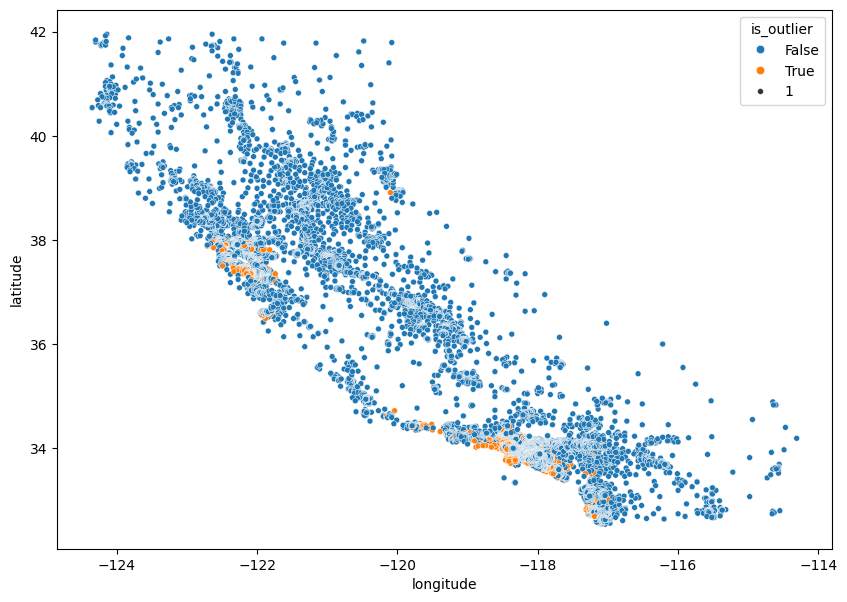

In [78]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_california_2, x="longitude", y="latitude", hue="is_outlier", size=1)
plt.show()

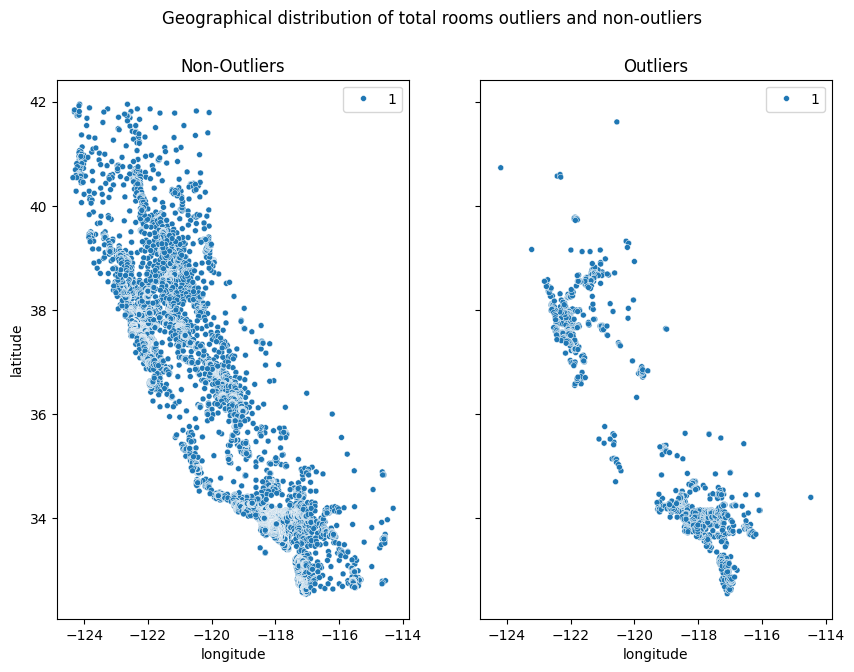

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex="row", sharey="row", figsize=(10,7))
ax = ax.flatten()
sns.scatterplot(data=df_california_2.query("is_rooms_outlier == False"), x="longitude", y="latitude", size=1, ax=ax[0])
ax[0].set_title("Non-Outliers")
sns.scatterplot(data=df_california_2.query("is_rooms_outlier == True"), x="longitude", y="latitude", size=1, ax=ax[1])
ax[1].set_title("Outliers")
plt.suptitle("Geographical distribution of total rooms outliers and non-outliers")
plt.show()

The geographical distribution is almost the same in but labels.

The outliers are around the big metropolis, but not every house around those falls into this denomination.

None of these clusters improved our guesses in relation to our target variable, even the `ocean_proximity` was better in showing us differences in their distribution.

We can pass to the Regression section and see which is the best model that we can get to predict the prices of the houses.

## Regression Models

We have explore the data and got some insights over which will be our interest variables to predict the houses price.

We will try different types of regression models and evaluate them via cross validation to choose the best hyperparameters that they can give us to our commitment.

**Note**: the Lasso's regularizated linear regression and the Random Forest's GridSearchCV can take up to 10 minutes each.

### Preprocessing

In [80]:
df_regression = df_california_2[["longitude", "latitude", "median_income", "median_house_value"]]

In [81]:
df_regression

longitude  latitude  median_income  median_house_value
0        -122.23     37.88         8.3252            452600.0
1        -122.22     37.86         8.3014            358500.0
2        -122.24     37.85         7.2574            352100.0
3        -122.25     37.85         5.6431            341300.0
4        -122.25     37.85         3.8462            342200.0
...          ...       ...            ...                 ...
20635    -121.09     39.48         1.5603             78100.0
20636    -121.21     39.49         2.5568             77100.0
20637    -121.22     39.43         1.7000             92300.0
20638    -121.32     39.43         1.8672             84700.0
20639    -121.24     39.37         2.3886             89400.0

[20433 rows x 4 columns]

As we saw during the EDA that the location and median_income were the best correlated variables with the price, those are the ones that we will keep.

In [82]:
X = df_regression.drop(columns=["median_house_value"])
y = df_regression["median_house_value"]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

We can go on with this.

### Linear Regression

In [84]:
pipeline = make_pipeline(PolynomialFeatures(), LinearRegression()) #just Ridge and Lasso need to be scaled

pol_grades = [1, 2, 3, 7, 9, 14]

param_grid = {
    'polynomialfeatures__degree': pol_grades,
    'linearregression__fit_intercept': [True],
}

pipeline_ridge = make_pipeline(PolynomialFeatures(), StandardScaler(), Ridge())
param_grid_ridge = {
    'polynomialfeatures__degree': pol_grades,
    'ridge__alpha': [0.01, 0.1, 1, 10],
    'ridge__fit_intercept': [True]
}

pipeline_lasso = make_pipeline(PolynomialFeatures(), StandardScaler(), Lasso())

param_grid_lasso = {
    'polynomialfeatures__degree': pol_grades,
    'lasso__alpha': [0.01, 0.1, 1, 10],
    'lasso__fit_intercept': [True]
}

pipelines = [pipeline, pipeline_ridge, pipeline_lasso]
parameters_list = [param_grid, param_grid_ridge, param_grid_lasso]

In [85]:
best_models = []
cross_val_scores = []

In [86]:
grid_search_lr = GridSearchCV(pipelines[0], parameters_list[0], scoring='neg_mean_squared_error', cv=5)
result_lr = grid_search_lr.fit(X_train, y_train)
cv_results_lr = result_lr.cv_results_
cross_val_scores.append(result_lr.best_score_)
best_models.append((result_lr.best_estimator_, result_lr.best_params_))

In [87]:
grid_search_ridge = GridSearchCV(pipelines[1], parameters_list[1], scoring='neg_mean_squared_error', cv=5)
result_ridge = grid_search_ridge.fit(X_train, y_train)
cv_results_ridge = result_ridge.cv_results_
cross_val_scores.append(result_ridge.best_score_)
best_models.append((result_ridge.best_estimator_, result_ridge.best_params_))

In [88]:
grid_search_lasso = GridSearchCV(pipelines[2], parameters_list[2], scoring='neg_mean_squared_error', cv=5)
result_lasso = grid_search_lasso.fit(X_train, y_train)
cv_results_lasso = result_lasso.cv_results_
cross_val_scores.append(result_lasso.best_score_)
best_models.append((result_lasso.best_estimator_, result_lasso.best_params_))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+13, tolerance: 1.749e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.527e+13, tolerance: 1.749e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.584e+13, tolerance: 1.723e

In [89]:
print("Train results based on GridSearchCV")
print(f"1st Pipeline = Linear Regression (without regularization)")
print(f"2nd Pipeline = Linear Regression with Ridge")
print(f"3rd Pipeline = Linear Regression with Lasso")

print("")
print("-----------------")
print("")

for i, (best_model, best_params) in enumerate(best_models):
    print(f"Best model for the {i+1} pipeline:\n{best_model}")
    print(f"Best parameters for the {i+1} pipeline:\n{best_params}")
    print(f"Cross Validation Negative MSE for the {i+1} pipeline best model:\n{cross_val_scores[i]:.2f}")
    print(f"R^2 score for the {i+1} pipeline best model:\n{r2_score(y_train, best_model.predict(X_train))}")
    print("")
    print("-----------------")
    print("")

Train results based on GridSearchCV
1st Pipeline = Linear Regression (without regularization)
2nd Pipeline = Linear Regression with Ridge
3rd Pipeline = Linear Regression with Lasso

-----------------

Best model for the 1 pipeline:
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=7)),
                ('linearregression', LinearRegression())])
Best parameters for the 1 pipeline:
{'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 7}
Cross Validation Negative MSE for the 1 pipeline best model:
-4476628636.40
R^2 score for the 1 pipeline best model:
0.6724802352683038

-----------------

Best model for the 2 pipeline:
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=14)),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.01))])
Best parameters for the 2 pipeline:
{'polynomialfeatures__degree': 14, 'ridge__alpha': 0.01, 'ridge__fit_intercept': True}
Cross Validation Negative MSE for the 2 pipel

The best linear regression model in the training was the one without the regularization, it has the highest a $R^2$ score of almost 0.70 and the highest Negative MSE.

In [108]:
lr = best_models[0][0]

In [109]:
best_lr = lr["linearregression"]

In [110]:
best_lr.coef_

array([-6.45967630e-02,  2.92103567e+02,  9.89906068e+00, -1.15409794e+01,
        2.13684757e+01,  2.51875043e+01, -2.29800025e+02,  9.47822678e+00,
       -2.83261951e+01, -6.47146217e+00, -7.85697504e+02, -9.24234913e+02,
        6.28125431e+03, -6.35369940e+02,  2.75217522e+03,  5.70329722e+02,
        8.06158647e+02, -2.22158404e+03, -4.33572112e+02, -6.48006019e+01,
        3.98060477e+03,  2.31160707e+04, -4.72658024e+04,  2.35835781e+04,
       -1.23862999e+05, -2.48151601e+04, -2.59443548e+04,  7.91127259e+04,
        1.53404929e+04,  2.29061744e+03,  1.69181817e+04, -3.58138109e+04,
       -6.75200594e+03, -1.12782251e+03, -3.94430377e+02, -2.09702929e+02,
       -3.24300524e+03, -2.38950893e+03, -1.61783638e+04, -1.27714487e+04,
       -1.71716855e+03, -2.81205010e+04, -2.07017421e+04, -5.23894732e+03,
        1.24477646e+03,  9.58280796e+02, -6.98069746e+03, -5.18089852e+03,
        2.82669008e+03,  7.43070982e+03,  3.04953007e+04,  2.20938542e+04,
        5.89614491e+03, -

As it is a 7th grade polynomium, it's not easy to interpretate their coefficients.

### KNN

In [92]:
pipeline_knn = make_pipeline(StandardScaler(), KNeighborsRegressor())

knn_k = [3, 5, 7, 9, 11, 13, 18, 21]

param_grid_knn = {
    "kneighborsregressor__n_neighbors": knn_k
}

In [93]:
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, scoring='neg_mean_squared_error', cv=5)
result_knn = grid_search_knn.fit(X_train, y_train)

In [104]:
print("Train results based on GridSearchCV for KNN")

print(f"Best KNN model:\n{result_knn.best_estimator_}")
print(f"Best parameters for the KNN model:\n{result_knn.best_params_}")
print(f"Cross Validation Negative MSE for the best KNN model:\n{result_knn.best_score_:.2f}")
print(f"R^2 score for the best KNN model:\n{r2_score(y_train, result_knn.best_estimator_.predict(X_train))}")

Train results based on GridSearchCV for KNN
Best KNN model:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=7))])
Best parameters for the KNN model:
{'kneighborsregressor__n_neighbors': 7}
Cross Validation Negative MSE for the best KNN model:
-3212205784.60
R^2 score for the best KNN model:
0.8266997337329755


In [95]:
knn = result_knn.best_estimator_["kneighborsregressor"]

The previous model Neg MSE was -4476628636, this is -3212205784. Our KNN has a better training score than the Linear Regression.

###Random Forest

In [97]:
n_trees = range(100, 401, 50)
max_trees_depth = range(1, 20, 3)

param_grid_rdmfrst = {
    "n_estimators": n_trees,
    "max_depth": max_trees_depth
}

In [99]:
grid_search_rdmfrst = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rdmfrst, scoring="neg_mean_squared_error", cv=5)
result_rdmfrst = grid_search_rdmfrst.fit(X_train, y_train)

In [105]:
print("Train results based on GridSearchCV for Random Forest")

print(f"Best Random Forest model:\n{result_rdmfrst.best_estimator_}")
print(f"Best parameters for the Random Forest model:\n{result_rdmfrst.best_params_}")
print(f"Cross Validation Negative MSE for the best Random Forest model:\n{result_rdmfrst.best_score_:.2f}")
print(f"R^2 score for the best Random Forest model:\n{r2_score(y_train, result_rdmfrst.best_estimator_.predict(X_train))}")

Train results based on GridSearchCV for Random Forest
Best Random Forest model:
RandomForestRegressor(max_depth=19, n_estimators=400, random_state=42)
Best parameters for the Random Forest model:
{'max_depth': 19, 'n_estimators': 400}
Cross Validation Negative MSE for the best Random Forest model:
-2317015777.37
R^2 score for the best Random Forest model:
0.9732946210282596


With 400 random trees and a max_depth of 19 we get a negative MSE of -2317015777. The KNN's one was -3212205784. It´s a big improve.

In [103]:
random_forest = result_rdmfrst.best_estimator_

### Model Selection

So far, we have tried three different types of regression models:

-  One based on model, the Linear Regression.
-  One based on instances, the KNN.
-  One based on ensamble, the Random Forest.

For each of them, we used K-folding Cross Validation with GridSearchCV to choosed the best combination of hyperparameters that gave the best *training* score.

We saw that based on the negative MSE and the $R^2$ scores, the Random Forest was the best one.

Now is time to choose which one is the one with the highest perfomance against data that they haven´t seen.

In [112]:
#Linear Regression
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

# KNN
y_pred_knn = knn.predict(X_test)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

# Random Forest
y_pred_rf = random_forest.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


In [114]:
print("Linear Regression")
print(f"RMSE: {rmse_lr:.2f}")
print(f"r2_score: {r2_lr}")
print("")
print("KNN")
print(f"RMSE: {rmse_knn:.2f}")
print(f"r2_score: {r2_knn}")
print("")
print("Random Forest")
print(f"RMSE: {rmse_rf:.2f}")
print(f"r2_scort: {r2_rf}")
print("")

Linear Regression
RMSE: 70971.06
r2_score: 0.6316764472160954

KNN
RMSE: 169465.08
r2_score: -1.1000391447218374

Random Forest
RMSE: 48034.05
r2_scort: 0.8312804559651776



Surprisingly, the KNN's test $R_2$ score has a negative value, this means that it doesn´t explain anything about the data variance and it is worse than some naive approach.

In relation to the Linear Regression: it isn´t that bad, it got a $R^2$ of almost 0.70 with the training set and here it dropped down to 0.63, something that we can consider reasonable but not really terrible.

The best score is from the Random Forest by far. It got a 0.97 with the training split and here it we can see that it keeps really strong. It dropped down more than the Linear Regression, but could hold a good 0.83.

This last one is the model that we will consider the best among the ones that we have trained.